# Automated tight Lyapunov analysis for first-order methods
#### Authors: Manu Upadhyaya, Sebastian Banert, Adrien Taylor and Pontus Giselsson

arXiv link: https://arxiv.org/abs/2302.06713

In [1]:
import numpy as np
import cvxpy as cp
import scs
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
def select_algorithm(name_param):

    if name_param[0] == "gradient":
        gamma = name_param[1]
        A = 1; B = -gamma; C=1; D=0

    if name_param[0] == "proximal_point":
        gamma = name_param[1]
        A = 1; B = -gamma; C=1; D=-gamma

    if name_param[0] == "proximal_gradient":
        gamma = name_param[1]
        A = 1
        B = -gamma*np.ones((1,2))
        C = np.ones((2,1))
        D = -gamma*np.array([[0,0],[1,1]])

    if name_param[0] == "gradient_heavy-ball":
        gamma = name_param[1]
        beta = name_param[2]
        A = np.array([[1+beta,-beta],[1,0]])
        B = np.array([[-gamma],[0]])
        C = np.array([[1,0]])
        D=0

    if name_param[0] == "proximal_gradient_heavy-ball_terms":
        gamma = name_param[1]
        delta1 = name_param[2]
        delta2 = name_param[3]

        A = np.array([[1+delta1+delta2,-delta1-delta2],[1,0]])
        B = np.array([[-gamma,-gamma],[0,0]])
        C = np.array([[1,0],[1+delta1,-delta1]])
        D = np.array([[0,0],[-gamma,-gamma]])

    if name_param[0] == "Douglas-Rachford":
        # Douglas–Rachford method
        gamma = name_param[1]
        lambd = name_param[2]

        A = 1
        B = -gamma*lambd*np.ones((1,2))
        C = np.ones((2,1))
        D = -gamma*np.array([[1,0],[2,1]])

    if name_param[0] == "Douglas-Rachford_momentum":
        # Douglas–Rachford method with momentum
        gamma = name_param[1]
        delta = name_param[2]
        alpha = name_param[3]
        lambd = name_param[4]

        A = np.array([[0,1],[-delta,1+delta]])
        B = -lambd*gamma*np.array([[1,1],[1+alpha+delta,1+alpha+delta]])
        C = np.array([[0,1],[0,1]])
        D = -gamma*np.array([[1,0],[2,1]])

    if name_param[0] == "Nesterov_accelerated_gradient":
        # https://link.springer.com/book/10.1007/978-3-319-91578-4
        # See Chapter 2.2: Constant step scheme, III
        sigma = name_param[1]
        beta = name_param[2]
        q = sigma/beta

        A = np.array([[2/(1+np.sqrt(q)),-(1-np.sqrt(q))/(1+np.sqrt(q))],[1,0]])
        B = np.array([[-1/beta],[0]])
        C = np.array([[2/(1+np.sqrt(q)),-(1-np.sqrt(q))/(1+np.sqrt(q))]])
        D = 0

    if name_param[0] == "Safavi_et_al.":
        # http://www.jbento.info/papers/nesterov_sdp.pdf
        # See Algorithm 1 and Theorem 7
        sigma = name_param[1]
        beta = name_param[2]
        kappa = beta/sigma

        _alpha = 1/beta
        _beta = (2*kappa-np.sqrt(2*kappa-1)-1)/(2*(kappa+np.sqrt(2*kappa-1)))

        A = np.array([[1+_beta,-_beta],[1,0]])
        B = np.array([[-_alpha],[0]])
        C = np.array([[1+_beta,-_beta]])
        D = 0

    if name_param[0] == "Triple_momentum_method":
        # https://ieeexplore.ieee.org/document/7967721
        # Triple momentum method
        sigma = name_param[1]
        beta = name_param[2]
        q = sigma/beta
        alpha = (2-np.sqrt(q))/beta
        _beta = (1-np.sqrt(q))**2/(1+np.sqrt(q))
        gamma = (1-np.sqrt(q))**2/((2-np.sqrt(q))*(1+np.sqrt(q)))

        A = np.array([[1+_beta,-_beta],[1,0]])
        B = np.array([[-alpha],[0]])
        C = np.array([[1+gamma,-gamma]])
        D = 0

    if name_param[0] == "strongly_convex_FISTA":
        sigma = name_param[1]
        beta = name_param[2]
        q = sigma/beta

        A = np.array([[2/(1+np.sqrt(q)),-(1-np.sqrt(q))/(1+np.sqrt(q))],[1,0]])
        B = np.array([[-1/beta,-1/beta],[0,0]])
        C = np.array([[2/(1+np.sqrt(q)),-(1-np.sqrt(q))/(1+np.sqrt(q))],[2/(1+np.sqrt(q)),-(1-np.sqrt(q))/(1+np.sqrt(q))]])
        D = np.array([[0,0],[-1/beta,-1/beta]])

    if name_param[0] == "Davis–Yin_splitting":
        # https://arxiv.org/pdf/1504.01032.pdf
        # Davis--Yin three-operator splitting method
        gamma = name_param[1]
        lambd = name_param[2]

        A = 1
        B = -gamma*lambd*np.array([[1,1,1]])
        C = np.array([[1],[1],[1]])
        D = -gamma*np.array([[1,0,0],[1,0,0],[2,1,1]])

    if name_param[0] == "Chambolle-Pock":
        tau_1 = name_param[1]
        tau_2 = name_param[2]
        theta = name_param[3]

        A = np.array([[1,-tau_1],[0,0]])
        B = np.array([[-tau_1,0],[0,1]])
        C = np.array([[1,-tau_1],[1,1/tau_2 - tau_1*(1+theta)]])
        D = np.array([[-tau_1,0],[-tau_1*(1+theta),-1/tau_2]])

    A = np.array(A, ndmin=2)
    B = np.array(B, ndmin=2)
    C = np.array(C, ndmin=2)
    D = np.array(D, ndmin=2)

    return (A,B,C,D)

In [14]:
def get_data_variables(A,B,C,D,L):
    m = C.shape[0]
    n = C.shape[1]

    if m == 1:
        case_mod_mat = np.block([[np.eye(n+2*m)],[np.zeros((m,n+2*m))]])
    else:
        N = np.block([[np.eye(m-1)],
                      [-np.ones((1,m-1))]])
        case_mod_mat = np.block([[np.eye(n+2*m),np.zeros((n+2*m,m-1))],[np.zeros((m,n+2*m)),N]])

    O_mn = np.zeros((m,n))
    O_nm = np.zeros((n,m))
    O_mm = np.zeros((m,m))
    I_m = np.eye(m)
    I_n = np.eye(n)

    E_0_1 = np.block([[C@(I_n-A),D-C@B,-D,C@B],
                  [O_mn,I_m,O_mm,O_mm],
                  [O_mn,O_mm,I_m,O_mm]])

    E_1_0 = np.block([[C@(A-I_n),C@B-D,D,-C@B],
                      [O_mn,O_mm,I_m,O_mm],
                      [O_mn,I_m,O_mm,O_mm]])

    E_0_s = np.block([[C,D,O_mm,-D],
                      [O_mn,I_m,O_mm,O_mm],
                      [O_mn,O_mm,O_mm,I_m]])

    E_s_0 = np.block([[-C,-D,O_mm,D],
                      [O_mn,O_mm,O_mm,I_m],
                      [O_mn,I_m,O_mm,O_mm]])

    E_1_s = np.block([[C@A,C@B,D,-D-C@B],
                      [O_mn,O_mm,I_m,O_mm],
                      [O_mn,O_mm,O_mm,I_m]])

    E_s_1 = np.block([[-C@A,-C@B,-D,D+C@B],
                      [O_mn,O_mm,O_mm,I_m],
                      [O_mn,O_mm,I_m,O_mm]])

    Sigma_0 = np.block([[I_n,O_nm,O_nm,O_nm],
                        [O_mn,I_m,O_mm,O_mm],
                        [O_mn,O_mm,O_mm,I_m]])

    Sigma_1 = np.block([[A,B,O_nm,-B],
                        [O_mn,O_mm,I_m,O_mm],
                        [O_mn,O_mm,O_mm,I_m]])

    H_0_1 = np.block([I_m,
                      -I_m])
    H_1_0 = np.block([-I_m,
                      I_m])
    H_0_s = np.block([I_m,
                      O_mm])
    H_s_0 = np.block([-I_m,
                      O_mm])
    H_1_s = np.block([O_mm,
                      I_m])
    H_s_1 = np.block([O_mm,
                      -I_m])

    E_0_1 = E_0_1@case_mod_mat
    E_1_0 = E_1_0@case_mod_mat
    E_0_s = E_0_s@case_mod_mat
    E_s_0 = E_s_0@case_mod_mat
    E_1_s = E_1_s@case_mod_mat
    E_s_1 = E_s_1@case_mod_mat

    Es_for_C1 = [E_0_1, E_1_0, E_0_s, E_s_0, E_1_s, E_s_1]
    Es_for_C2 = [E_0_s, E_s_0]

    Sigma_0 = Sigma_0@case_mod_mat
    Sigma_1 = Sigma_1@case_mod_mat

    H_0_1 = np.block([I_m,
                      -I_m])
    H_1_0 = np.block([-I_m,
                      I_m])
    H_0_s = np.block([I_m,
                      O_mm])
    H_s_0 = np.block([-I_m,
                      O_mm])
    H_1_s = np.block([O_mm,
                      I_m])
    H_s_1 = np.block([O_mm,
                      -I_m])

    Hs_for_C1 = [H_0_1, H_1_0, H_0_s, H_s_0, H_1_s, H_s_1]
    Hs_for_C2 = [H_0_s, H_s_0]

    C1_M = []
    C1_a = []
    for l in L:
        for i in range(len(Es_for_C1)):
            C1_M += [Es_for_C1[i].T@l[0]@Es_for_C1[i]]
            C1_a += [np.reshape(Hs_for_C1[i].T@l[1],(2*m,-1))]

    C2_M = []
    C2_a = []
    for l in L:
        for i in range(len(Es_for_C2)):
            C2_M += [Es_for_C2[i].T@l[0]@Es_for_C2[i]]
            C2_a += [np.reshape(Hs_for_C2[i].T@l[1],(2*m,-1))]

    return Sigma_0, Sigma_1, C1_M, C1_a, C2_M, C2_a

In [15]:
def find_quadratic_Lyapunov_function(A,B,C,D,L,P,p,T,t,rho):

    T_and_t_equal_to_zero = np.all(T == 0) and np.all(t == 0)

    # Problem data
    m = C.shape[0]
    n = C.shape[1]
    Sigma_0, Sigma_1, C1_M, C1_a, C2_M, C2_a = get_data_variables(A,B,C,D,L)
    I_m = np.eye(m)

    # Optimization variables
    C1_lambda = cp.Variable(len(L)*6)
    C2_lambda = cp.Variable(len(L)*2)
    if not T_and_t_equal_to_zero:
        C3_lambda = cp.Variable(len(L)*2)
    Q = cp.Variable((n+2*m,n+2*m), symmetric=True)
    q = cp.Variable((m,1))
    if not T_and_t_equal_to_zero:
        S = cp.Variable((n+2*m,n+2*m), symmetric=True)
        s = cp.Variable((m,1))

    # Constraints
    constraints = [C1_lambda>=0]
    C1_M_val = 0
    C1_a_val = 0
    for i in range(len(C1_M)):
        C1_M_val += C1_lambda[i]*C1_M[i]
        C1_a_val += C1_lambda[i]*C1_a[i]
    if not T_and_t_equal_to_zero:
        constraints += [Sigma_0.T@(rho*Q-S)@Sigma_0 - Sigma_1.T@Q@Sigma_1 + C1_M_val >> 0,
                        cp.bmat([ [rho*q-s],[-q] ]) + C1_a_val == 0]
    else:
        constraints += [Sigma_0.T@(rho*Q)@Sigma_0 - Sigma_1.T@Q@Sigma_1 + C1_M_val >> 0,
                        cp.bmat([ [rho*q],[-q] ]) + C1_a_val == 0]

    constraints += [C2_lambda>=0]
    C2_M_val = 0
    C2_a_val = 0
    for i in range(len(C2_M)):
        C2_M_val += C2_lambda[i]*C2_M[i]
        C2_a_val += C2_lambda[i]*C2_a[i]
    constraints += [Sigma_0.T@(Q-P)@Sigma_0 + C2_M_val >> 0,
                    cp.bmat([[q-p],[np.zeros((m,1))]]) + C2_a_val == 0]

    if not T_and_t_equal_to_zero:
        constraints += [C3_lambda>=0]
        C3_M_val = 0
        C3_a_val = 0
        for i in range(len(C2_M)):
            C3_M_val += C3_lambda[i]*C2_M[i]
            C3_a_val += C3_lambda[i]*C2_a[i]
        constraints += [Sigma_0.T@(S-T)@Sigma_0 + C3_M_val >> 0,
                        cp.bmat([ [s-t], [np.zeros((m,1))] ]) + C3_a_val == 0]

    # Objective
    obj = cp.Minimize(0)

    # Problem
    prob = cp.Problem(obj, constraints)

    # Solve with MOSEK.
    prob.solve(
    solver=cp.SCS,
    eps=1e-9,          # try 1e-5 if slow
    max_iters=300000,  # often needed for SDPs
    acceleration_lookback=0,
    verbose=False
)

    if prob.value == float('inf'):
        return False
    else:
        return True

In [16]:
def bisection(A,B,C,D,L,P,p,T,t,tol=0.001):
    rho = 1
    try:
        if not find_quadratic_Lyapunov_function(A,B,C,D,L,P,p,T,t,rho):
            return -1
    except cp.error.SolverError:
        return -1
    u=1
    l=0.001
    try:
        while u-l>tol:
            rho = (l+u)/2
            if find_quadratic_Lyapunov_function(A,B,C,D,L,P,p,T,t,rho):
                u = rho
            else:
                l = rho
    except cp.error.SolverError:
        pass
    return u

In [17]:
# Interpolation

## Smooth strongly convex
def smooth_strongly_convex(sigma, beta):
    M = np.array([[beta*sigma,-sigma,beta],
                  [-sigma,1,-1],
                  [beta,-1,1]])/(2*(beta-sigma))
    a = -1
    return (M,a)

## strongly convex
def strongly_convex(sigma):
    M = np.array([[sigma,0,1],
                  [0,0,0],
                  [1,0,0]])/2
    a = -1
    return (M,a)

def get_product_interpolation(list_of_sigmas_and_betas):
    m = len(list_of_sigmas_and_betas)
    L_no_lift = []
    for (sigma, beta) in list_of_sigmas_and_betas:
        if beta == float('inf'):
            L_no_lift += [strongly_convex(sigma)]
        else:
            L_no_lift += [smooth_strongly_convex(sigma, beta)]
    L = []
    for l in range(m):
        e_l = np.zeros(m); e_l[l] = 1
        (M, a) = L_no_lift[l]
        L += [(np.kron(M,np.diag(e_l)),e_l*a)]

    return L

In [18]:
def check_sufficient_Slater(A,B,C,D,list_of_sigmas_and_betas):
    m = C.shape[0]
    delta = np.empty(m)
    for i in range(m):
        (sigma, beta) = list_of_sigmas_and_betas[i]
        if beta == float('inf'):
            delta[i] = sigma + 1
        else:
            delta[i] = (sigma + beta)/2
    Delta = np.diag(delta)

    temp = np.eye(m) - Delta@D

    if np.isfinite(np.linalg.cond(temp)):
        inv = np.linalg.inv(temp)
        M = np.block([[inv@Delta@C],
                      [inv@Delta@C@(A+B@(inv@Delta@C))],
                      [inv@Delta@C-inv@Delta@C@(A+B@(inv@Delta@C))]])
        if np.all(np.linalg.norm(M, axis=1)>np.finfo(float).eps):
            return True
        else:
            return False
    else:
        return False

def check_Slater_numerically(A,B,C,D,list_of_sigmas_and_betas,tol=1e-4):

    # Problem data
    L = get_product_interpolation(list_of_sigmas_and_betas)
    m = C.shape[0]
    n = C.shape[1]
    _, _, _, _, C2_M, C2_a = get_data_variables(A,B,C,D,L)

    # Optimization variables
    chi = cp.Variable(2*m)
    G = cp.Variable((n+3*m-1,n+3*m-1), PSD=True)

    # Constraints
    constraints = [G >> tol*np.eye(n+3*m-1)]
    for i in range(len(C2_M)):
        constraints += [C2_a[i].T@chi + cp.trace(C2_M[i]@G) <= 0]

    # Objective
    obj = cp.Minimize(0)

    # Problem
    prob = cp.Problem(obj, constraints)

    # Solve with MOSEK.
    prob.solve(
    solver=cp.SCS,
    eps=1e-9,          # try 1e-5 if slow
    max_iters=300000,  # often needed for SDPs
    acceleration_lookback=0,
    verbose=False
)

    if prob.value == float('inf'):
        return False
    else:
        return True

def has_Slater(A,B,C,D,list_of_sigmas_and_betas):
    return (check_sufficient_Slater(A,B,C,D,list_of_sigmas_and_betas) or
            check_Slater_numerically(A,B,C,D,list_of_sigmas_and_betas))

## Numerical examples - Linear rates

---
### Gradient method

Let $\gamma \in \mathbb{R}_{++}$, $0 \leq \sigma_1 < \beta_1 < +\infty$ and $f_{1}\in\mathcal{F}_{\sigma_1,\beta_1}$. The gradient method is given by

\begin{align*}
    x_{k+1} = x_{k} - \gamma \nabla f_1(x_{k}).
\end{align*}

By letting $\mathbf{x}_{k} = x_{k}$, $\mathbf{y}_k=x_k$ and $\mathbf{u}_k=\nabla f_1(y_k)$, we get

\begin{equation*}
    \begin{aligned}
        \mathbf{x}_{k+1} &= \mathbf{x}_k - \gamma \mathbf{u}_k, \\
        \mathbf{y}_k &=  \mathbf{x}_k,  \\
        \mathbf{u}_k &\in \boldsymbol{\partial} \mathbf{f} (\mathbf{y}_k),
    \end{aligned}
\end{equation*}

where $\boldsymbol{\partial}\mathbf{f}(y)=\{\nabla f_1(y)\}$ for each $y\in\mathcal{H}$ (since $f_1$ is differentiable). We identify the state-space form

\begin{align*}
    A &=1,&
    B &=-\gamma,&
    C &=1,&
    D &= 0.
\end{align*}

We pick

\begin{align*}
    (P,p,T,t) = \left(e_1e_1^\top,0,0,0\right)
\end{align*}

where $e_1$ is the first standard basis vector of $\mathbb{R}^{n+2m}$ ($n=1$ and $m=1$), and bisect to find the smallest $\rho$ for which a $(P,p,T,t,\rho)$-quadratic Lyapunov inequality exists. Note that

\begin{align*}
    \mathcal{Q}\left(P,\left(\mathbf{x}_k-\mathbf{x}_{\star},\mathbf{u}_{k},\mathbf{u}_{\star}\right)\right) + p^{\top}(\mathbf{F}_{k}-\mathbf{F}_{\star}) = \lVert{x_{k} - x_{\star}\rVert}^{2}.
\end{align*}

In [20]:
# Gradient method

# Function class data
sigma = 1
beta = 2
list_of_sigmas_and_betas = [(sigma, beta)]
L = get_product_interpolation(list_of_sigmas_and_betas)

gammas = []
tight_rhos = []
PEP_rhos = []
for gamma in np.linspace(0.01,2/beta,50):
        choice = ("gradient", gamma)
        (A,B,C,D) = select_algorithm(choice)
        m = C.shape[0]
        n = C.shape[1]
        P = np.zeros((n+2*m,n+2*m)); P[0,0] = 1
        p = np.zeros((m,1))
        T = np.zeros((n+2*m,n+2*m))
        t = np.zeros((m,1))

        if not has_Slater(A,B,C,D,list_of_sigmas_and_betas):
            continue

        PEP_rho = bisection(A,B,C,D,L,P,p,T,t,tol=0.0001)
        if PEP_rho == -1:
            continue

        PEP_rhos.append(PEP_rho)
        gammas.append(gamma)
        tight_rhos.append(max([beta*gamma-1,1-gamma*sigma]) ** 2)

fig, axes = plt.subplots(dpi = 150, figsize=(10, 3))
axes.plot(gammas, PEP_rhos,'b*')
axes.plot(gammas, tight_rhos,'c')
axes.grid(True)
axes.legend([r'Contraction via PEP', r'Theoretical tight contraction: $\left(\max(\gamma\beta_1-1,1-\gamma\sigma_1)\right)^2$'])
axes.set_xlabel(r'$\gamma$')
axes.set_ylabel(r'$\rho$')
axes.set_title(r'Gradient method: $f_1\in\mathcal{F}_{\sigma_1,\beta_1}$, $\sigma_1='+f'{sigma}'+r'$, $\beta_1='+f'{beta}'+r'$');

from scipy.io import savemat

savemat(
    "py_gradient_method_data.mat",
    {
        "gamma": np.array(gammas),
        "PEP_rho": np.array(PEP_rhos),
        "tight_rho": np.array(tight_rhos),
    }
)


---
### Proximal point method

Let $\sigma_1\in\mathbb{R}_{+}$, $\gamma \in \mathbb{R}_{++}$ and $f_{1}\in\mathcal{F}_{\sigma_1,\infty}$. The poximal point method is given by

\begin{align*}
    x_{k+1}=\text{prox}_{\gamma f_1}(x_k)=\text{argmin}_{x\in\mathcal{H}}\left(f_1(x)+\tfrac{1}{2\gamma}\|x-x_k\|^2\right),
\end{align*}

which is equivalent to that

\begin{align*}
    \frac{x_{k}-x_{k+1}}{\gamma}\in\partial f_1(x_{k+1}).
\end{align*}

By letting $\mathbf{x}_{k} = x_{k}$, $\mathbf{y}_k=x_{k+1}$ and $\mathbf{u}_k=\gamma^{-1}(x_k-x_{k+1})$, we get

\begin{equation*}
    \begin{aligned}
        \mathbf{x}_{k+1} &= \mathbf{x}_k - \gamma \mathbf{u}_k, \\
        \mathbf{y}_k &=  \mathbf{x}_k - \gamma \mathbf{u}_k,  \\
        \mathbf{u}_k &\in \boldsymbol{\partial} \mathbf{f} (\mathbf{y}_k),
    \end{aligned}
\end{equation*}

where $\boldsymbol{\partial}\mathbf{f}(y)=\partial f_1(y)$ for each $y\in\mathcal{H}$. We identify

\begin{align*}
    A &=1,&
    B &=-\gamma,&
    C &=1,&
    D &= -\gamma.
\end{align*}

We pick

\begin{align*}
    (P,p,T,t) = \left(e_1e_1^\top,0,0,0\right)
\end{align*}

where $e_1$ is the first standard basis vector of $\mathbb{R}^{n+2m}$ ($n=1$ and $m=1$), and bisect to find the smallest $\rho$ for which a $(P,p,T,t,\rho)$-quadratic Lyapunov inequality exists. Note that

\begin{align*}
    \mathcal{Q}\left(P,\left(\mathbf{x}_k-\mathbf{x}_{\star},\mathbf{u}_{k},\mathbf{u}_{\star}\right)\right) + p^{\top}(\mathbf{F}_{k}-\mathbf{F}_{\star}) = \lVert{x_{k} - x_{\star}\rVert}^{2}.
\end{align*}

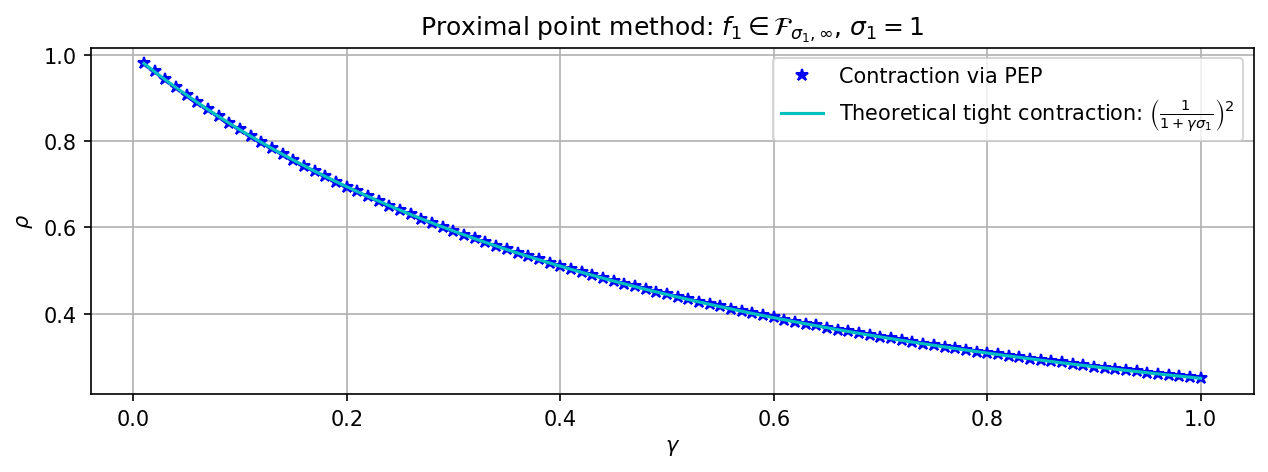

In [ ]:
# Proximal point method

# Function data
sigma = 1

beta = float('inf')
list_of_sigmas_and_betas = [(sigma, beta)]
L = get_product_interpolation(list_of_sigmas_and_betas)

gammas = []
tight_rhos = []
PEP_rhos = []
for gamma in np.linspace(0.01,1,100):

        choice = ("proximal_point", gamma)
        (A,B,C,D) = select_algorithm(choice)
        m = C.shape[0]
        n = C.shape[1]
        P = np.zeros((n+2*m,n+2*m)); P[0,0] = 1;
        p = np.zeros((m,1))
        T = np.zeros((n+2*m,n+2*m))
        t = np.zeros((m,1))

        if not has_Slater(A,B,C,D,list_of_sigmas_and_betas):
            continue

        PEP_rho = bisection(A,B,C,D,L,P,p,T,t,tol=0.001)
        if PEP_rho == -1:
            continue

        PEP_rhos.append(PEP_rho)
        gammas.append(gamma)
        tight_rhos.append((1/(1+gamma*sigma)) ** 2)

fig, axes = plt.subplots(dpi = 150, figsize=(10, 3))
axes.plot(gammas, PEP_rhos,'b*')
axes.plot(gammas, tight_rhos,'c')
axes.grid(True)
axes.legend([r'Contraction via PEP', r'Theoretical tight contraction: $\left(\frac{1}{1+\gamma\sigma_1}\right)^2$'])
axes.set_xlabel(r'$\gamma$')
axes.set_ylabel(r'$\rho$')
axes.set_title(r'Proximal point method: $f_1\in\mathcal{F}_{\sigma_1,\infty}$, $\sigma_1 = '+f'{sigma}'+r'$');

---
### Proximal gradient method

Let $\gamma \in \mathbb{R}_{++}$, $0 \leq \sigma_1 < \beta_1 < +\infty$, $f_{1}\in\mathcal{F}_{\sigma_1,\beta_1}$ and $f_{2}\in\mathcal{F}_{0,\infty}$. The proximal gradient method is given by

\begin{align*}
    x_{k+1}&=\text{prox}_{\gamma f_2}(x_k-\gamma\nabla f_1(x_k))\\
           &=\text{argmin}_{x\in\mathcal{H}}\left(f_2(x)+\tfrac{1}{2\gamma}\|x-(x_k-\gamma\nabla f_1(x_k))\|^2\right).
\end{align*}

This in turn is equivalent to that

\begin{align*}
    \frac{(x_k-\gamma\nabla f_1(x_k))-x_{k+1}}{\gamma}&\in\partial f_2(x_{k+1}).
\end{align*}

By letting $\mathbf{x}_{k}=x_k$, $\mathbf{y}_{k}=(x_k,x_{k+1})$ and $\mathbf{u}_{k} = (\nabla f_1(x_k),\gamma^{-1}(x_k-\gamma \nabla f_1(x_k)-x_{k+1}))$, we get

\begin{equation*}
    \begin{aligned}
        \mathbf{x}_{k+1} &= \mathbf{x}_k+\left(\begin{bmatrix}-\gamma&-\gamma\end{bmatrix}\otimes\text{Id} \right)\mathbf{u}_{k}, \\
        \mathbf{y}_{k} &= \left(\begin{bmatrix}1\\1\end{bmatrix}\otimes\text{Id}\right) \mathbf{x}_k+\left(\begin{bmatrix}0&0\\-\gamma&-\gamma\end{bmatrix}\otimes\text{Id}\right) \mathbf{u}_{k}, \\
        \mathbf{u}_{k} &\in \boldsymbol{\partial}\mathbf{f}(\mathbf{y}_{k}),
    \end{aligned}    
\end{equation*}

where $\boldsymbol{\partial}\mathbf{f}(\mathbf{y})=\{\nabla f_{1}(y^{(1)})\}\times\partial f_2(y^{(2)})$ for each $\mathbf{y}=(y^{(1)},y^{(2)})\in\mathcal{H}^2$. We identify

\begin{align*}
    A &=1,&
    B &=\begin{bmatrix}-\gamma&-\gamma\end{bmatrix},&
    C &=\begin{bmatrix}1\\1\end{bmatrix},&
    D &= \begin{bmatrix}0&0\\-\gamma&-\gamma\end{bmatrix}.
\end{align*}

We pick

\begin{align*}
    (P,p,T,t) = \left(e_1e_1^\top,0,0,0\right)
\end{align*}

where $e_1$ is the first standard basis vector of $\mathbb{R}^{n+2m}$ ($n=1$ and $m=2$), and bisect to find the smallest $\rho$ for which a $(P,p,T,t,\rho)$-quadratic Lyapunov inequality exists. Note that

\begin{align*}
    \mathcal{Q}\left(P,\left(\mathbf{x}_k-\mathbf{x}_{\star},\mathbf{u}_{k},\mathbf{u}_{\star}\right)\right) + p^{\top}(\mathbf{F}_{k}-\mathbf{F}_{\star}) = \lVert{x_{k} - x_{\star}\rVert}^{2}.
\end{align*}

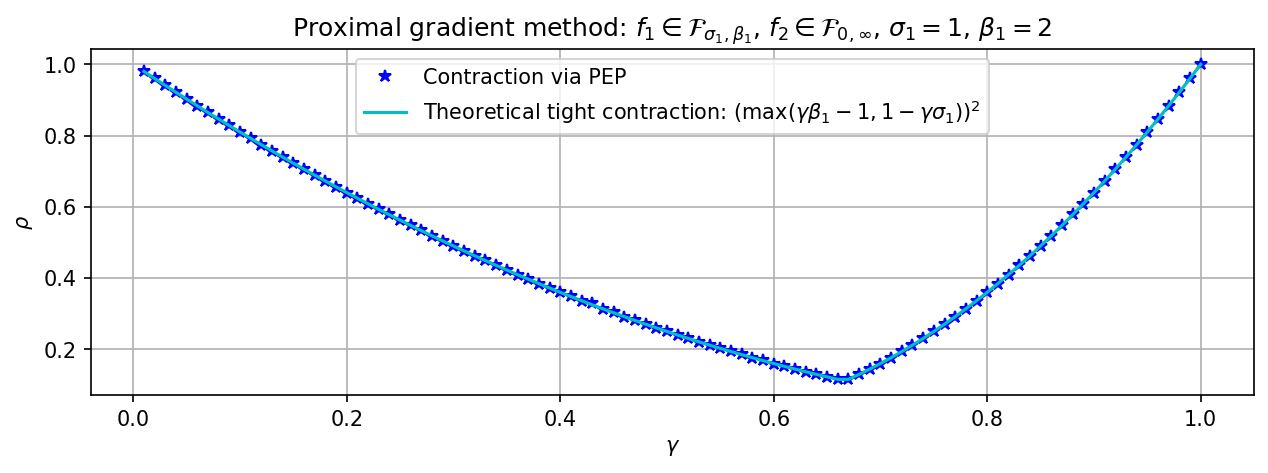

In [ ]:
# Proximal gradient method

sigma = 1
beta = 2
list_of_sigmas_and_betas = [(sigma, beta),(0, float('inf'))]
L = get_product_interpolation(list_of_sigmas_and_betas)

gammas = []
tight_rhos = []
PEP_rhos = []
for gamma in np.linspace(0.01,2/beta,100):
        choice = ("proximal_gradient", gamma)
        (A,B,C,D) = select_algorithm(choice)
        m = C.shape[0]
        n = C.shape[1]
        P = np.zeros((n+2*m,n+2*m)); P[0,0] = 1
        p = np.zeros((m,1))
        T = np.zeros((n+2*m,n+2*m))
        t = np.zeros((m,1))

        if not has_Slater(A,B,C,D,list_of_sigmas_and_betas):
            continue

        PEP_rho = bisection(A,B,C,D,L,P,p,T,t,tol=0.001)
        if PEP_rho == -1:
            continue

        PEP_rhos.append(PEP_rho)
        gammas.append(gamma)
        tight_rhos.append(max([beta*gamma-1,1-gamma*sigma]) ** 2)

fig, axes = plt.subplots(dpi = 150, figsize=(10, 3))
axes.plot(gammas, PEP_rhos,'b*')
axes.plot(gammas, tight_rhos,'c')
axes.grid(True)
axes.legend([r'Contraction via PEP', r'Theoretical tight contraction: $\left(\max(\gamma\beta_1-1,1-\gamma\sigma_1)\right)^2$'])
axes.set_xlabel(r'$\gamma$')
axes.set_ylabel(r'$\rho$')
axes.set_title(r'Proximal gradient method: $f_1\in\mathcal{F}_{\sigma_1,\beta_1}$, $f_2\in\mathcal{F}_{0,\infty}$, $\sigma_1='+f'{sigma}'+r'$, $\beta_1='+f'{beta}'+r'$');

---
### Gradient method with heavy-ball momentum
Let $\gamma \in \mathbb{R}_{++}$, $\delta\in\mathbb{R}$, $0 \leq \sigma_1 < \beta_1 < +\infty$ and $f_{1}\in\mathcal{F}_{\sigma_1,\beta_1}$. The gradient method with heavy-ball momentum is given by

\begin{align*}
    x_{k+1} = x_k-\gamma\nabla f_1(x_k)+\delta(x_k-x_{k-1}).
\end{align*}

By letting $\mathbf{x}_{k}=(x_{k},x_{k-1})$, $\mathbf{y}_k=x_{k}$, and $\mathbf{u}_k=\nabla f_1(x_k)$, we get

\begin{equation*}
    \begin{aligned}
        \mathbf{x}_{k+1}&=\left(\begin{bmatrix}1+\delta&-\delta\\1&0\end{bmatrix}\otimes \text{Id}\right)\mathbf{x}_{k}+\left(\begin{bmatrix}-\gamma\\0 \end{bmatrix}\otimes\text{Id}\right)\mathbf{u}_k,\\
        \mathbf{y}_k&=\left(\begin{bmatrix}1&0\end{bmatrix}\otimes \text{Id}\right)\mathbf{x}_{k}, \\
        \mathbf{u}_{k} &\in \boldsymbol{\partial}\mathbf{f}(\mathbf{y}_{k}),
    \end{aligned}
\end{equation*}

where $\boldsymbol{\partial}\mathbf{f}(y)=\{\nabla f_1(y)\}$ for each $y\in\mathcal{H}$. We identify

\begin{align*}
    A &=\begin{bmatrix}1+\delta&-\delta\\1&0\end{bmatrix},&
    B &=\begin{bmatrix}-\gamma\\0 \end{bmatrix},&
    C &=\begin{bmatrix}1&0\end{bmatrix},&
    D &=0.
\end{align*}

We pick

\begin{align*}
    (P,p,T,t) = \left(e_1e_1^\top,0,0,0\right)
\end{align*}

where $e_1$ is the first standard basis vector of $\mathbb{R}^{n+2m}$ ($n=2$ and $m=1$), and bisect to find the smallest $\rho$ for which a $(P,p,T,t,\rho)$-quadratic Lyapunov inequality exists. Note that

\begin{align*}
    \mathcal{Q}\left(P,\left(\mathbf{x}_k-\mathbf{x}_{\star},\mathbf{u}_{k},\mathbf{u}_{\star}\right)\right) + p^{\top}(\mathbf{F}_{k}-\mathbf{F}_{\star}) = \lVert{x_{k} - x_{\star}\rVert}^{2}.
\end{align*}

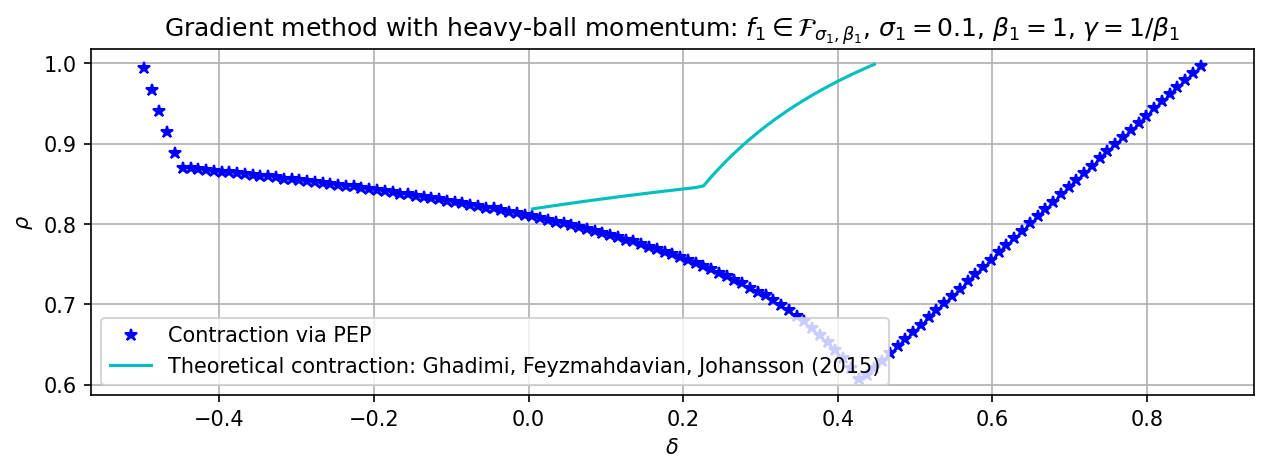

In [ ]:
# Gradient method with heavy-ball momentum

def Ghadimi_rate(gamma, delta, sigma, beta):
    # Ghadimi, Feyzmahdavian, Johansson - Global convergence of the Heavy-ball method for convex optimization
    q1 = delta/(delta + sigma*(2*(1-delta)/(beta+sigma) - gamma))
    q2 = max(0,1-2*gamma*sigma*beta/((1-delta)*(beta+sigma)+2*beta*delta))
    return max(q1,q2)

# Function class data
sigma = 0.1
beta = 1
list_of_sigmas_and_betas = [(sigma, beta)]
L = get_product_interpolation(list_of_sigmas_and_betas)

# Algorithm data
gamma = 1/beta

Ghadimi_deltas = []
Ghadimi_rhos = []
PEP_deltas = []
PEP_rhos = []
for delta in np.linspace(-1,1,200):
        if (gamma < 2*(1-delta)/(beta+sigma)) and (0 <= delta < 1):
            Ghadimi_rhos.append(Ghadimi_rate(gamma, delta, sigma, beta))
            Ghadimi_deltas.append(delta)

        choice = ("gradient_heavy-ball", gamma, delta)
        (A,B,C,D) = select_algorithm(choice)
        m = C.shape[0]
        n = C.shape[1]
        P = np.zeros((n+2*m,n+2*m)); P[0,0] = 1
        p = np.zeros((m,1))
        T = np.zeros((n+2*m,n+2*m))
        t = np.zeros((m,1))

        if not has_Slater(A,B,C,D,list_of_sigmas_and_betas):
            continue

        PEP_rho = bisection(A,B,C,D,L,P,p,T,t,tol=0.001)
        if PEP_rho == -1:
            continue

        PEP_rhos.append(PEP_rho)
        PEP_deltas.append(delta)


fig, axes = plt.subplots(dpi = 150, figsize=(10, 3))
axes.plot(PEP_deltas, PEP_rhos,'b*')
axes.plot(Ghadimi_deltas, Ghadimi_rhos,'c')
axes.grid(True)
axes.legend([r'Contraction via PEP', r'Theoretical contraction: Ghadimi, Feyzmahdavian, Johansson (2015)'])
axes.set_xlabel(r'$\delta$')
axes.set_ylabel(r'$\rho$')
axes.set_title(r'Gradient method with heavy-ball momentum: $f_1\in\mathcal{F}_{\sigma_1,\beta_1}$, $\sigma_1='+f'{sigma}'+r'$, $\beta_1='+f'{beta}'+r'$, $\gamma = 1 / \beta_1$');

---
### Proximal gradient method with heavy-ball momentum terms
Let $\gamma \in \mathbb{R}_{++}$, $\delta_1,\delta_2\in\mathbb{R}$, $0 \leq \sigma_1 < \beta_1 < +\infty$, $f_{1}\in\mathcal{F}_{\sigma_1,\beta_1}$ and $f_{2}\in\mathcal{F}_{0,\infty}$. A proximal gradient method with heavy-ball momentum terms is given by

\begin{align*}
    x_{k+1} = \text{prox}_{\gamma f_2}(x_k-\gamma\nabla f_1(x_k)+\delta_1(x_k-x_{k-1}))+\delta_2(x_k-x_{k-1}).
\end{align*}

By letting  $\mathbf{x}_{k}=(x_{k},x_{k-1})$, $\mathbf{y}_{k}=(x_k,x_{k+1}-\delta_2(x_k-x_{k-1}))$, $\mathbf{u}_{k}=(\nabla f_1(x_k),\gamma^{-1}(x_k-\gamma \nabla f_1(x_k)+(\delta_1+\delta_2)(x_k-x_{k-1})-x_{k+1}))$, we get

\begin{equation*}
    \begin{aligned}
        \mathbf{x}_{k+1}   &=  
        \left(\begin{bmatrix}1+\delta_1+\delta_2&-\delta_1-\delta_2\\1&0\end{bmatrix}\otimes \text{Id}\right)\mathbf{x}_{k} +
        \left(\begin{bmatrix}-\gamma&-\gamma\\0&0 \end{bmatrix}\otimes\text{Id}\right)\mathbf{u}_{k} \\
        \mathbf{y}_{k} &=    
        \left(\begin{bmatrix}1&0\\1+\delta_1&-\delta_1\end{bmatrix}\otimes \text{Id}\right)\mathbf{x}_{k} +
        \left(\begin{bmatrix}0&0\\-\gamma&-\gamma \end{bmatrix}\otimes\text{Id}\right)\mathbf{u}_{k}, \\
        \mathbf{u}_{k}&\in\boldsymbol{\partial}\mathbf{f}(\mathbf{y}_{k}),
    \end{aligned}
\end{equation*}

where $\boldsymbol{\partial}\mathbf{f}(\mathbf{y})=\{\nabla f_{1}(y^{(1)})\}\times\partial f_2(y^{(2)})$ for each $\mathbf{y}=(y^{(1)},y^{(2)})\in\mathcal{H}^2$. We identify

\begin{align*}
    A &=\begin{bmatrix}1+\delta_1+\delta_2&-\delta_1-\delta_2\\1&0\end{bmatrix},&
    B &=\begin{bmatrix}-\gamma&-\gamma\\0&0 \end{bmatrix},&
    C &=\begin{bmatrix}1&0\\1+\delta_1&-\delta_1\end{bmatrix},&
    D &=\begin{bmatrix}0&0\\-\gamma&-\gamma \end{bmatrix}.
\end{align*}

We pick

\begin{align*}
    (P,p,T,t) = \left(e_1e_1^\top,0,0,0\right)
\end{align*}

where $e_1$ is the first standard basis vector of $\mathbb{R}^{n+2m}$ ($n=2$ and $m=2$), and bisect to find the smallest $\rho$ for which a $(P,p,T,t,\rho)$-quadratic Lyapunov inequality exists. Note that

\begin{align*}
    \mathcal{Q}\left(P,\left(\mathbf{x}_k-\mathbf{x}_{\star},\mathbf{u}_{k},\mathbf{u}_{\star}\right)\right) + p^{\top}(\mathbf{F}_{k}-\mathbf{F}_{\star}) = \lVert{x_{k} - x_{\star}\rVert}^{2}.
\end{align*}

In [22]:
# Proximal gradient method with heavy-ball momentum terms

# Function class data
sigma = 1
beta = 3
list_of_sigmas_and_betas = [(sigma, beta),(0,float('inf'))]
L = get_product_interpolation(list_of_sigmas_and_betas)

gammas = [2/(sigma + beta), 1/beta]

PEP_rhos = [[],[]]
delta_1s = [[],[]]

for delta_1 in np.linspace(0,0.4,100):
    for i, gamma in enumerate(gammas):
        delta_2 = 0
        choice = ("proximal_gradient_heavy-ball_terms", gamma, delta_1, delta_2)
        (A,B,C,D) = select_algorithm(choice)
        m = C.shape[0]
        n = C.shape[1]
        P = np.zeros((n+2*m,n+2*m)); P[0,0] = 1
        p = np.zeros((m,1))
        T = np.zeros((n+2*m,n+2*m))
        t = np.zeros((m,1))

        if not has_Slater(A,B,C,D,list_of_sigmas_and_betas):
            continue

        PEP_rho = bisection(A,B,C,D,L,P,p,T,t,tol=0.001)
        if PEP_rho == -1:
            continue

        PEP_rhos[i].append(PEP_rho)
        delta_1s[i].append(delta_1)

fig, axes = plt.subplots(nrows=3, ncols=1, dpi = 150, figsize=(10, 10))
axes[0].plot(delta_1s[0], PEP_rhos[0],'b*')
axes[0].plot(delta_1s[1], PEP_rhos[1],'k*')
axes[0].grid(True)
axes[0].set_xlabel(r'$\delta_1$')
axes[0].set_ylabel(r'$\rho$')
axes[0].set_title(r'Proximal gradient method with heavy-ball momentum terms: $f_1\in\mathcal{F}_{\sigma_1,\beta_1}$, $f_2\in\mathcal{F}_{0,\infty}$, $\sigma_1='+f'{sigma}'+r'$, $\beta_1='+f'{beta}'+r'$');
axes[0].legend([r'Contraction via PEP: $\gamma = 2/(\sigma_1 + \beta_1)$, $\delta_2 = 0$', r'Contraction via PEP: $\gamma = 1/\beta_1$, $\delta_2 = 0$'])


savemat(
    "py_proxHB_data.mat",
    {
        # step sizes
        "gamma": np.array(gammas),

        # delta_1 grids (one per gamma)
        "delta_1_gamma1": np.array(delta_1s[0]),
        "delta_1_gamma2": np.array(delta_1s[1]),

        # PEP contraction factors
        "PEP_rho_gamma1": np.array(PEP_rhos[0]),
        "PEP_rho_gamma2": np.array(PEP_rhos[1]),
    }
)





---
### Douglas–Rachford method

Let $\gamma \in \mathbb{R}_{++}$, $\lambda\in\mathbb{R}\setminus\{0\}$, $0 \leq \sigma_1 < \beta_1 \leq +\infty$, $f_{1}\in\mathcal{F}_{\sigma_1,\beta_1}$ and $f_{2}\in\mathcal{F}_{0,\infty}$. The Douglas--Rachford method is given by

\begin{equation*}
    \begin{aligned}
        y_{k}^{(1)}&=\text{prox}_{\gamma f_1}(x_k),\\
        y_{k}^{(2)}&=\text{prox}_{\gamma f_2}(2y_k^{(1)}-x_k),\\
        x_{k+1}&=x_k+\lambda(y_k^{(2)}-y_k^{(1)}).
    \end{aligned}
\end{equation*}

By letting $\mathbf{x}_{k}=x_{k}$, $\mathbf{y}_{k}=(y_k^{(1)},y_k^{(2)})$ and $\mathbf{u}_{k}=(\gamma^{-1}(x_k-y_k^{(1)}),\gamma^{-1}(2y_k^{(1)}-x_k-y_k^{(2)}))$, we get

\begin{align*}
    \mathbf{x}_{k+1}&=\mathbf{x}_k+\lambda\left(\begin{bmatrix}-\gamma&-\gamma\end{bmatrix}\otimes\text{Id}\right)\mathbf{u}_{k},\\
    \mathbf{y}_{k}&=\left(\begin{bmatrix} 1\\1\end{bmatrix}\otimes\text{Id}\right)\mathbf{x}_k+\left(\begin{bmatrix}-\gamma&0\\-2\gamma&-\gamma\end{bmatrix}\otimes\text{Id}\right)\mathbf{u}_{k},\\
    \mathbf{u}_{k}&\in\boldsymbol{\partial}\mathbf{f}(\mathbf{y}_{k}),
\end{align*}

where $\boldsymbol{\partial}\mathbf{f}(\mathbf{y})=\partial f_1(y^{(1)})\times\partial f_2(y^{(2)})$ for each $\mathbf{y}=(y^{(1)},y^{(2)})\in\mathcal{H}^2$. We identify

\begin{align*}
    A &=1,&
    B &=\begin{bmatrix}-\gamma\lambda&-\gamma\lambda\end{bmatrix},&
    C &=\begin{bmatrix} 1\\1\end{bmatrix},&
    D &=\begin{bmatrix}-\gamma&0\\-2\gamma&-\gamma\end{bmatrix}.
\end{align*}

We pick

\begin{align*}
    (P,p,T,t) = \left(\begin{bmatrix}C & D & -D\end{bmatrix}^{\top} e_1e_1^{\top} \begin{bmatrix}C & D & -D\end{bmatrix},0,0,0\right)
\end{align*}

where $e_1$ is the first standard basis vector of $\mathbb{R}^{m}$ ($m=2$), and bisect to find the smallest $\rho$ for which a $(P,p,T,t,\rho)$-quadratic Lyapunov inequality exists. Note that

\begin{align*}
    \mathcal{Q}\left(P,\left(\mathbf{x}_k-\mathbf{x}_{\star},\mathbf{u}_{k},\mathbf{u}_{\star}\right)\right) + p^{\top}(\mathbf{F}_{k}-\mathbf{F}_{\star}) = \lVert{y_{k}^{(1)} - y_{\star}^{(1)}\rVert}^{2}.
\end{align*}

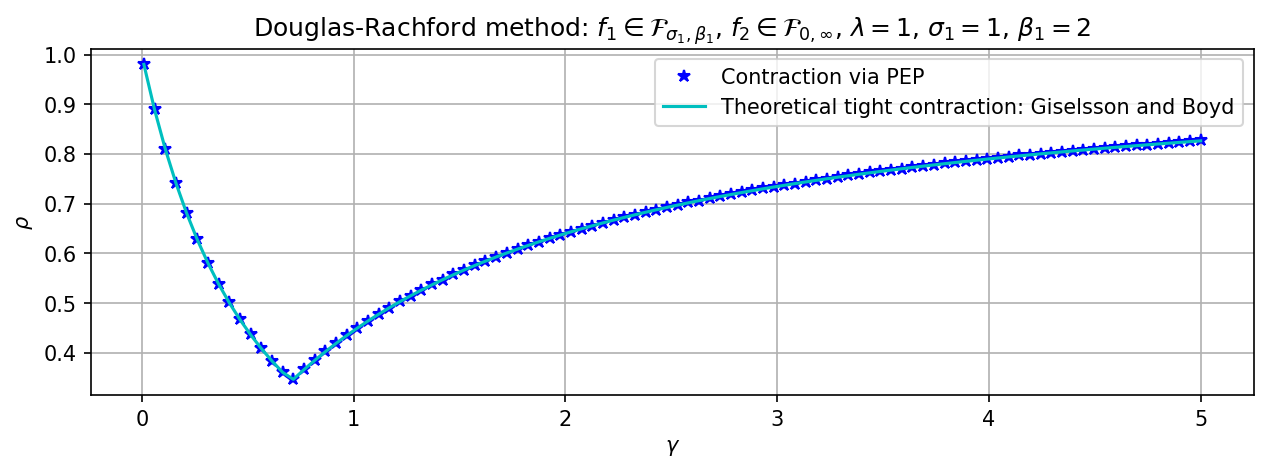

In [ ]:
# Douglas–Rachford method

def get_delta_contraction(beta, sigma, gamma):
    # Giselsson and Boyd
    return max([(gamma*beta-1)/(gamma*beta+1),(1-gamma*sigma)/(1+gamma*sigma)])

def tight_rate(lambd, sigma, beta, gamma):
    # Giselsson and Boyd
    delta = get_delta_contraction(beta, sigma, gamma)
    return (np.abs(1-lambd/2)+(lambd/2)*delta)**2

# Function data
sigma = 1
beta = 2
list_of_sigmas_and_betas = [(sigma, beta),(0, float('inf'))]
L = get_product_interpolation(list_of_sigmas_and_betas)

# DR data
lambd = 1

gammas = []
tight_rhos = []
PEP_rhos = []
for gamma in np.linspace(0.01,5,100):

    delta = get_delta_contraction(beta, sigma, gamma)

    if lambd/2 < 2/(1+delta):

        choice = ("Douglas-Rachford", gamma, lambd)
        (A,B,C,D) = select_algorithm(choice)
        m = C.shape[0]
        n = C.shape[1]
        temp = np.block([C,D,-D])
        mid = np.zeros((m,m)); mid[0,0] = 1;
        P = temp.T@mid@temp
        p = np.zeros((m,1))
        T = np.zeros((n+2*m,n+2*m))
        t = np.zeros((m,1))

        if not has_Slater(A,B,C,D,list_of_sigmas_and_betas):
            continue

        PEP_rho = bisection(A,B,C,D,L,P,p,T,t,tol=0.001)
        if PEP_rho == -1:
            continue

        PEP_rhos.append(PEP_rho)
        gammas.append(gamma)
        tight_rhos.append(tight_rate(lambd, sigma, beta, gamma))

fig, axes = plt.subplots(dpi = 150, figsize=(10, 3))
axes.plot(gammas, PEP_rhos,'b*')
axes.plot(gammas, tight_rhos,'c')
axes.grid(True)
axes.legend([r'Contraction via PEP', r'Theoretical tight contraction: Giselsson and Boyd'])
axes.set_xlabel(r'$\gamma$')
axes.set_ylabel(r'$\rho$')
axes.set_title(r'Douglas-Rachford method: $f_1\in\mathcal{F}_{\sigma_1,\beta_1}$, $f_2\in\mathcal{F}_{0,\infty}$, $\lambda = 1$, $\sigma_1='+f'{sigma}'+r'$, $\beta_1='+f'{beta}'+r'$');

---
### Douglas–Rachford method with momentum

Let $\alpha \in \mathbb{R} \setminus\{-1\}$, $\gamma \in\mathbb{R}_{++}$, $\delta \in \mathbb{R}$, $\lambda \in \mathbb{R} \setminus\{0\}$, $0 \leq \sigma_1 < \beta_1 \leq +\infty$, $f_{1}\in\mathcal{F}_{\sigma_1,\beta_1}$ and $f_{2}\in\mathcal{F}_{0,\infty}$. Consider the Douglas--Rachford method variation with momentum terms given by

\begin{equation*}
    \begin{aligned}
        y_k&=\text{prox}_{\gamma f_1}(u_k),\\
        z_k&=\text{prox}_{\gamma f_2}(2y_k-u_k),\\
        x_{k+1}&=u_k+\lambda(z_k-y_k),\\
        u_{k+1}&=x_{k+1}+\delta(x_{k+1}-x_k)+\alpha(x_{k+1}-u_k).    
    \end{aligned}
\end{equation*}

By letting $\mathbf{x}_{k}=(x_k,u_k)$, $\mathbf{y}_{k}=(y_k,z_k)$ and $\mathbf{u}_{k}=(\gamma^{-1}(u_k-y_k),\gamma^{-1}(2y_k-u_k-z_k))$, we get

\begin{equation*}
    \begin{aligned}
    \mathbf{x}_{k+1}   &=  
    \left(\begin{bmatrix}
                0 & 1 \\
                -\delta & 1 + \delta
    \end{bmatrix}\otimes \text{Id}\right)\mathbf{x}_{k} +
    \left(- \lambda \gamma \begin{bmatrix}
                1 & 1 \\
                1 + \alpha + \delta & 1 + \alpha + \delta
    \end{bmatrix}\otimes\text{Id}\right)\mathbf{u}_{k}, \\
    \mathbf{y}_{k} &=    
    \left(\begin{bmatrix}
                0 & 1 \\
                0 & 1
    \end{bmatrix}\otimes \text{Id}\right)\mathbf{x}_{k} +  
    \left( \begin{bmatrix}
                -\gamma & 0 \\
                -2\gamma & -\gamma
    \end{bmatrix}\otimes\text{Id}\right)\mathbf{u}_{k}, \\
    \mathbf{u}_{k}&\in\boldsymbol{\partial}\mathbf{f}(\mathbf{y}_{k}),
    \end{aligned}
\end{equation*}

where $\boldsymbol{\partial}\mathbf{f}(\mathbf{y})=\partial f_1(y^{(1)})\times\partial f_2(y^{(2)})$ for each $\mathbf{y}=(y^{(1)},y^{(2)})\in\mathcal{H}^2$. We identify

\begin{align*}
    A &=\begin{bmatrix}
                0 & 1 \\
                -\delta & 1 + \delta \end{bmatrix},&
    B &=- \lambda \gamma \begin{bmatrix}
                1 & 1 \\
                1 + \alpha + \delta & 1 + \alpha + \delta \end{bmatrix},&
    C &=\begin{bmatrix}
                0 & 1 \\
                0 & 1     \end{bmatrix},&
    D &=\begin{bmatrix}
                -\gamma & 0 \\
                -2\gamma & -\gamma \end{bmatrix}.
\end{align*}


We pick

\begin{align*}
    (P,p,T,t) = \left(\begin{bmatrix}C & D & -D\end{bmatrix}^{\top} e_1e_1^{\top} \begin{bmatrix}C & D & -D\end{bmatrix},0,0,0\right)
\end{align*}

where $e_1$ is the first standard basis vector of $\mathbb{R}^{m}$ ($m=2$), and bisect to find the smallest $\rho$ for which a $(P,p,T,t,\rho)$-quadratic Lyapunov inequality exists. Note that

\begin{align*}
    \mathcal{Q}\left(P,\left(\mathbf{x}_k-\mathbf{x}_{\star},\mathbf{u}_{k},\mathbf{u}_{\star}\right)\right) + p^{\top}(\mathbf{F}_{k}-\mathbf{F}_{\star}) = \lVert{y_{k} - y_{\star}\rVert}^{2}.
\end{align*}

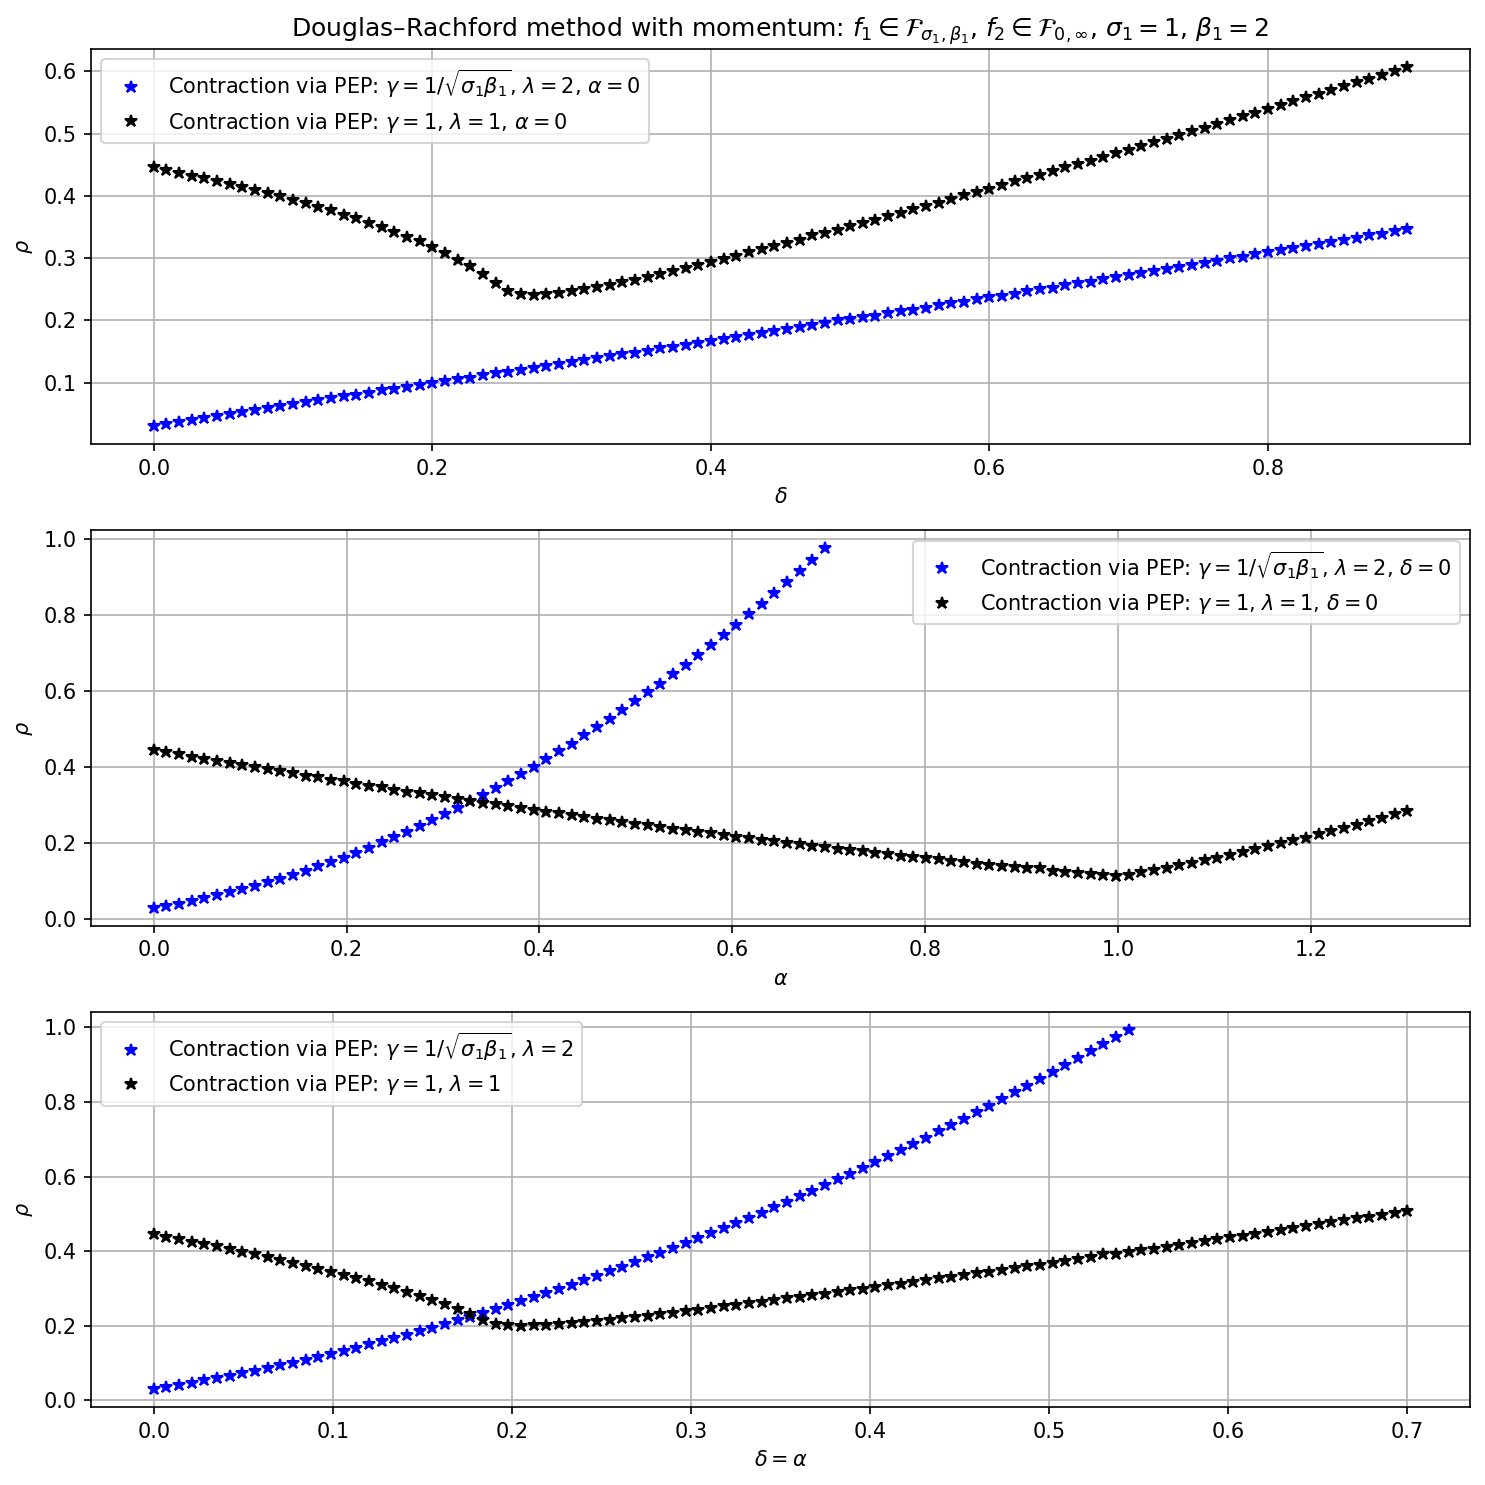

In [ ]:
# Douglas–Rachford method with momentum

# Function class data
sigma = 1
beta = 2
list_of_sigmas_and_betas = [(sigma, beta),(0,float('inf'))]
L = get_product_interpolation(list_of_sigmas_and_betas)


# DR data
lambdas = [2 , 1]
gammas = [1/np.sqrt(sigma*beta), 1]


PEP_rhos = [[],[]]
deltas = [[],[]]
for delta in np.linspace(0,0.9,100):
    for i, gamma in enumerate(gammas):
        alpha = 0
        lambd = lambdas[i]
        choice = ("Douglas-Rachford_momentum", gamma, delta, alpha, lambd)
        (A,B,C,D) = select_algorithm(choice)
        m = C.shape[0]
        n = C.shape[1]
        temp = np.block([C,D,-D])
        mid = np.zeros((m,m)); mid[0,0] = 1;
        P = temp.T@mid@temp
        p = np.zeros((m,1))
        T = np.zeros((n+2*m,n+2*m))
        t = np.zeros((m,1))

        if not has_Slater(A,B,C,D,list_of_sigmas_and_betas):
            continue

        PEP_rho = bisection(A,B,C,D,L,P,p,T,t,tol=0.001)
        if PEP_rho == -1:
            continue

        PEP_rhos[i].append(PEP_rho)
        deltas[i].append(delta)

fig, axes = plt.subplots(nrows=3, ncols=1, dpi = 150, figsize=(10, 10))
axes[0].plot(deltas[0], PEP_rhos[0],'b*')
axes[0].plot(deltas[1], PEP_rhos[1],'k*')
axes[0].grid(True)
axes[0].set_xlabel(r'$\delta$')
axes[0].set_ylabel(r'$\rho$')
axes[0].set_title(r'Douglas–Rachford method with momentum: $f_1\in\mathcal{F}_{\sigma_1,\beta_1}$, $f_2\in\mathcal{F}_{0,\infty}$, $\sigma_1='+f'{sigma}'+r'$, $\beta_1='+f'{beta}'+r'$');
axes[0].legend([r'Contraction via PEP: $\gamma = 1/\sqrt{\sigma_1 \beta_1}$, $\lambda = 2$, $\alpha = 0$', r'Contraction via PEP: $\gamma = 1$, $\lambda = 1$, $\alpha = 0$'])


PEP_rhos = [[],[]]
alphas = [[],[]]
for alpha in np.linspace(0,1.3,100):
    for i, gamma in enumerate(gammas):
        delta = 0
        lambd = lambdas[i]
        choice = ("Douglas-Rachford_momentum", gamma, delta, alpha, lambd)
        (A,B,C,D) = select_algorithm(choice)
        m = C.shape[0]
        n = C.shape[1]
        temp = np.block([C,D,-D])
        mid = np.zeros((m,m)); mid[0,0] = 1;
        P = temp.T@mid@temp
        p = np.zeros((m,1))
        T = np.zeros((n+2*m,n+2*m))
        t = np.zeros((m,1))

        if not has_Slater(A,B,C,D,list_of_sigmas_and_betas):
            continue

        PEP_rho = bisection(A,B,C,D,L,P,p,T,t,tol=0.001)
        if PEP_rho == -1:
            continue

        PEP_rhos[i].append(PEP_rho)
        alphas[i].append(alpha)

axes[1].plot(alphas[0], PEP_rhos[0],'b*')
axes[1].plot(alphas[1], PEP_rhos[1],'k*')
axes[1].grid(True)
axes[1].set_xlabel(r'$\alpha$')
axes[1].set_ylabel(r'$\rho$')
axes[1].legend([r'Contraction via PEP: $\gamma = 1/\sqrt{\sigma_1 \beta_1}$, $\lambda = 2$, $\delta = 0$', r'Contraction via PEP: $\gamma = 1$, $\lambda = 1$, $\delta = 0$'])

PEP_rhos = [[],[]]
alpha_delta_s = [[],[]]
for alpha_delta in np.linspace(0,0.7,100):
    for i, gamma in enumerate(gammas):
        lambd = lambdas[i]
        choice = ("Douglas-Rachford_momentum", gamma, alpha_delta, alpha_delta, lambd)
        (A,B,C,D) = select_algorithm(choice)
        m = C.shape[0]
        n = C.shape[1]
        temp = np.block([C,D,-D])
        mid = np.zeros((m,m)); mid[0,0] = 1;
        P = temp.T@mid@temp
        p = np.zeros((m,1))
        T = np.zeros((n+2*m,n+2*m))
        t = np.zeros((m,1))

        if not has_Slater(A,B,C,D,list_of_sigmas_and_betas):
            continue

        PEP_rho = bisection(A,B,C,D,L,P,p,T,t,tol=0.001)
        if PEP_rho == -1:
            continue

        PEP_rhos[i].append(PEP_rho)
        alpha_delta_s[i].append(alpha_delta)

axes[2].plot(alpha_delta_s[0], PEP_rhos[0],'b*')
axes[2].plot(alpha_delta_s[1], PEP_rhos[1],'k*')
axes[2].grid(True)
axes[2].set_xlabel(r'$\delta=\alpha$')
axes[2].set_ylabel(r'$\rho$')
axes[2].legend([r'Contraction via PEP: $\gamma = 1/\sqrt{\sigma_1 \beta_1}$, $\lambda = 2$', r'Contraction via PEP: $\gamma = 1$, $\lambda = 1$'])
fig.tight_layout()

---  
### Nesterov accelerated gradient method

Let $0 < \sigma_1 < \beta_1 < +\infty$, $f_1\in\mathcal{F}_{\sigma_1,\beta_1}$ and denote by $q = \sigma_1/\beta_1$ the inverse condition number ($0< q < 1$). Nesterov's accelerated gradient method with constant momentum is given by

\begin{equation*}
    \begin{aligned}
        x_{k+1}&=y_k-\frac{1}{\beta_1}\nabla f_1(y_k),\\
        y_k&=x_k+\frac{1-\sqrt{q}}{1+\sqrt{q}}(x_k-x_{k-1}).
    \end{aligned}
\end{equation*}

By letting  $\mathbf{x}_{k} = (x_k,x_{k-1})$, $\mathbf{y}_{k}=y_k$ and $\mathbf{u}_{k}= \nabla f_1(y_{k})$, we get

\begin{equation*}
    \begin{aligned}
        \mathbf{x}_{k+1}&=\left(\begin{bmatrix}
        \frac{2}{1+\sqrt{q}} & -\frac{1-\sqrt{q}}{1+\sqrt{q}}\\1 & 0
        \end{bmatrix}\otimes \text{Id}\right)\mathbf{x}_{k}+\left(\begin{bmatrix}
        -\frac{1}{\beta_1}\\0
        \end{bmatrix}\otimes\text{Id}\right)\mathbf{u}_{k},\\
        \mathbf{y}_{k}&=\left(\begin{bmatrix}
        \frac{2}{1+\sqrt{q}} & -\frac{1-\sqrt{q}}{1+\sqrt{q}}
        \end{bmatrix}\otimes \text{Id}\right)\mathbf{x}_{k}, \\
        \mathbf{u}_{k}&\in\boldsymbol{\partial}\mathbf{f}(\mathbf{y}_{k}),
        \end{aligned}
\end{equation*}

where $\boldsymbol{\partial}\mathbf{f}(y)=\{\nabla f_1(y)\}$ for each $y\in\mathcal{H}$. We identify

\begin{align*}
    A &=\begin{bmatrix}
        \frac{2}{1+\sqrt{q}} & -\frac{1-\sqrt{q}}{1+\sqrt{q}}\\1 & 0
        \end{bmatrix},&
    B &=\begin{bmatrix}
        -\frac{1}{\beta_1}\\0
        \end{bmatrix},&
    C &=\begin{bmatrix}
        \frac{2}{1+\sqrt{q}} & -\frac{1-\sqrt{q}}{1+\sqrt{q}}
        \end{bmatrix},&
    D &=0.
\end{align*}


We pick

\begin{align*}
    (P,p,T,t) = \left(\begin{bmatrix}C & D & -D\end{bmatrix}^{\top} \begin{bmatrix}C & D & -D\end{bmatrix},0,0,0\right)
\end{align*}

and bisect to find the smallest $\rho$ for which a $(P,p,T,t,\rho)$-quadratic Lyapunov inequality exists. Note that

\begin{align*}
    \mathcal{Q}\left(P,\left(\mathbf{x}_k-\mathbf{x}_{\star},\mathbf{u}_{k},\mathbf{u}_{\star}\right)\right) + p^{\top}(\mathbf{F}_{k}-\mathbf{F}_{\star}) = \lVert{y_{k} - y_{\star}\rVert}^{2}.
\end{align*}


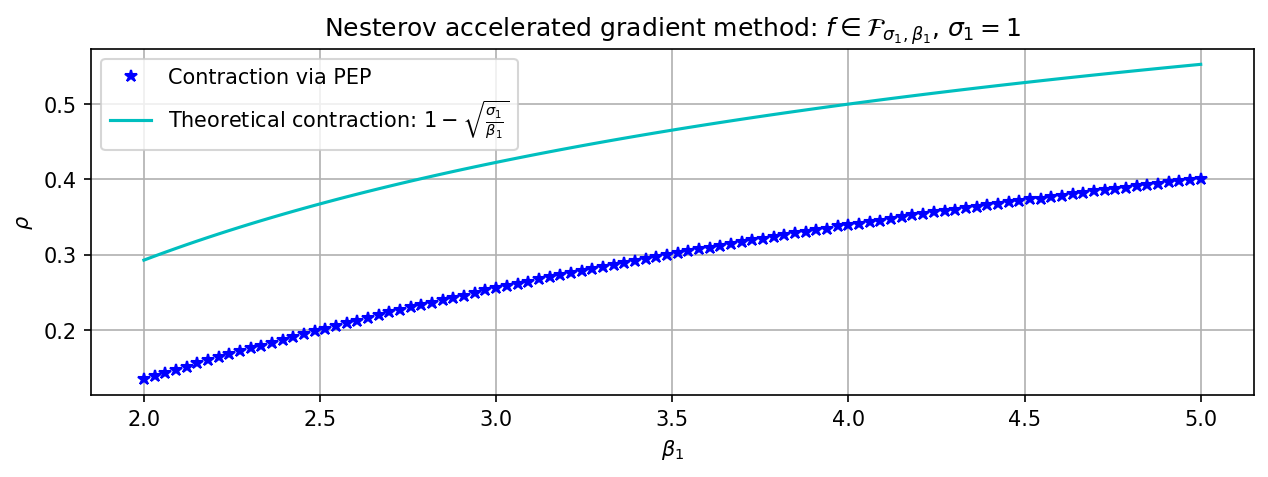

In [ ]:
# Nesterov accelerated gradient method
sigma = 1

betas = []
rhos = []
PEP_rhos = []
for beta in np.linspace(2,5,100):
        choice = ("Nesterov_accelerated_gradient", sigma, beta)
        (A,B,C,D) = select_algorithm(choice)
        m = C.shape[0]
        n = C.shape[1]
        #P = np.zeros((n+2*m,n+2*m)); P[0,0] = 1;
        temp = np.block([C,D,-D])
        P = temp.T@temp
        p = np.zeros((m,1))
        T = np.zeros((n+2*m,n+2*m))
        t = np.zeros((m,1))

        # Function data
        list_of_sigmas_and_betas = [(sigma, beta)]
        L = get_product_interpolation(list_of_sigmas_and_betas)

        if not has_Slater(A,B,C,D,list_of_sigmas_and_betas):
            continue

        PEP_rho = bisection(A,B,C,D,L,P,p,T,t,tol=0.001)
        if PEP_rho == -1:
            continue

        PEP_rhos.append(PEP_rho)
        betas.append(beta)
        rhos.append(1-np.sqrt(sigma/beta))

fig, axes = plt.subplots(dpi = 150, figsize=(10, 3))
axes.plot(betas, PEP_rhos,'b*')
axes.plot(betas, rhos,'c')
axes.grid(True)
axes.legend([r'Contraction via PEP', r'Theoretical contraction: $1-\sqrt{\frac{\sigma_1}{\beta_1}}$'])
axes.set_xlabel(r'$\beta_1$')
axes.set_ylabel(r'$\rho$')
axes.set_title(r"Nesterov accelerated gradient method: $f\in\mathcal{F}_{\sigma_1,\beta_1}$, $\sigma_1 = "+f"{sigma}"+r"$");

---
### Safavi et al.

TODO

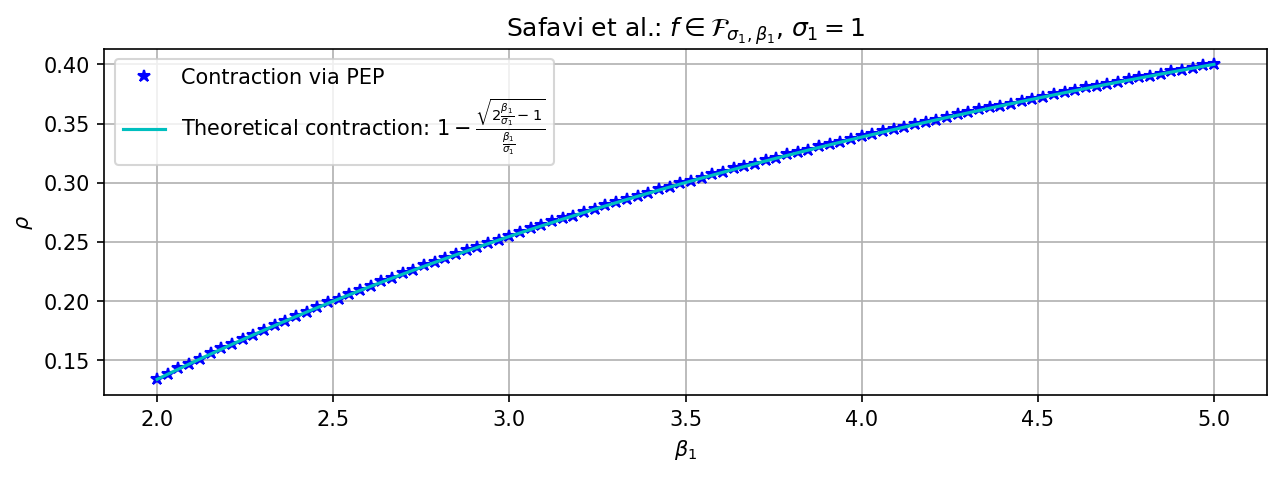

In [ ]:
# Nesterov’s accelerated method (NAM) as per:
# http://www.jbento.info/papers/nesterov_sdp.pdf
sigma = 1

betas = []
rhos = []
PEP_rhos = []
for beta in np.linspace(2,5,100):
        choice = ("Safavi_et_al.", sigma, beta)
        (A,B,C,D) = select_algorithm(choice)
        m = C.shape[0]
        n = C.shape[1]
        P = np.zeros((n+2*m,n+2*m)); P[0,0] = 1;
        p = np.zeros((m,1))
        T = np.zeros((n+2*m,n+2*m))
        t = np.zeros((m,1))

        # Function data
        list_of_sigmas_and_betas = [(sigma, beta)]
        L = get_product_interpolation(list_of_sigmas_and_betas)

        if not has_Slater(A,B,C,D,list_of_sigmas_and_betas):
            continue

        PEP_rho = bisection(A,B,C,D,L,P,p,T,t,tol=0.001)
        if PEP_rho == -1:
            continue

        PEP_rhos.append(PEP_rho)
        betas.append(beta)
        rhos.append(1-np.sqrt(2*beta/sigma - 1)/(beta/sigma))

fig, axes = plt.subplots(dpi = 150, figsize=(10, 3))
axes.plot(betas, PEP_rhos,'b*')
axes.plot(betas, rhos,'c')
axes.grid(True)
axes.legend([r'Contraction via PEP', r'Theoretical contraction: $1-\frac{\sqrt{2\frac{\beta_1}{\sigma_1} - 1}}{\frac{\beta_1}{\sigma_1}}$'])
axes.set_xlabel(r'$\beta_1$')
axes.set_ylabel(r'$\rho$')
axes.set_title(r'Safavi et al.: $f\in\mathcal{F}_{\sigma_1,\beta_1}$, $\sigma_1 = '+f'{sigma}'+r'$');

---
### Triple momentum method

Let $0 < \sigma_1 < \beta_1 < +\infty$, $f_1\in\mathcal{F}_{\sigma_1,\beta_1}$ and $q = \sigma_1/\beta_1$. The triple momentum method is given by

\begin{equation*}
    \begin{aligned}
        x_{k+1} &= x_k + \hat\beta (x_k - x_{k-1}) - \alpha \nabla f_1(y_k), \\
        y_k &= x_k + \gamma (x_k - x_{k-1}),
    \end{aligned}
\end{equation*}

where

\begin{equation*}
    \begin{aligned}
        \alpha = \frac{2-\sqrt{q}}{\beta_1}, \quad \hat\beta = \frac{(1-\sqrt{q})^2}{1+\sqrt{q}}, \quad \gamma = \frac{(1-\sqrt{q})^2}{(2-\sqrt{q})(1+\sqrt{q})}.
    \end{aligned}
\end{equation*}

By letting  $\mathbf{x}_{k} = (x_k,x_{k-1})$, $\mathbf{y}_{k}=y_k$ and $\mathbf{u}_{k}= \nabla f_1(y_{k})$, we get

\begin{equation*}
    \begin{aligned}
        \mathbf{x}_{k+1}&=\left(\begin{bmatrix}
        1+\hat\beta & -\hat\beta\\
        1 & 0
        \end{bmatrix}\otimes \text{Id}\right)\mathbf{x}_{k}+\left(\begin{bmatrix}
        -\alpha\\
        0
        \end{bmatrix}\otimes\text{Id}\right)\mathbf{u}_{k},\\
        \mathbf{y}_{k}&=\left(\begin{bmatrix}
        1+\gamma & -\gamma
        \end{bmatrix}\otimes \text{Id}\right)\mathbf{x}_{k}, \\
        \mathbf{u}_{k}&\in\boldsymbol{\partial}\mathbf{f}(\mathbf{y}_{k}),
        \end{aligned}
\end{equation*}

where $\boldsymbol{\partial}\mathbf{f}(y)=\{\nabla f_1(y)\}$ for each $y\in\mathcal{H}$. We identify

\begin{align*}
    A &=\begin{bmatrix}
        1+\hat\beta & -\hat\beta\\
        1 & 0
        \end{bmatrix},&
    B &=\begin{bmatrix}
        -\alpha\\
        0
        \end{bmatrix},&
    C &=\begin{bmatrix}
        1+\gamma & -\gamma
        \end{bmatrix},&
    D &=0.
\end{align*}

We pick

\begin{align*}
    (P,p,T,t) = \left(\begin{bmatrix}C & D & -D\end{bmatrix}^{\top} \begin{bmatrix}C & D & -D\end{bmatrix},0,0,0\right)
\end{align*}

and bisect to find the smallest $\rho$ for which a $(P,p,T,t,\rho)$-quadratic Lyapunov inequality exists. Note that

\begin{align*}
    \mathcal{Q}\left(P,\left(\mathbf{x}_k-\mathbf{x}_{\star},\mathbf{u}_{k},\mathbf{u}_{\star}\right)\right) + p^{\top}(\mathbf{F}_{k}-\mathbf{F}_{\star}) = \lVert{y_{k} - y_{\star}\rVert}^{2}.
\end{align*}


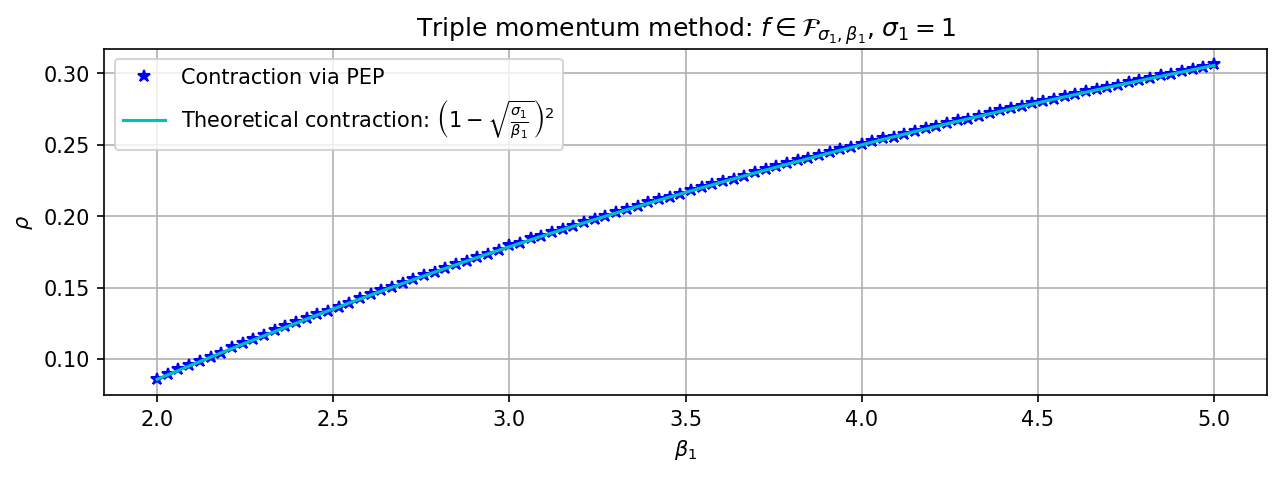

In [ ]:
# Triple momentum method
sigma = 1

betas = []
rhos = []
PEP_rhos = []
for beta in np.linspace(2,5,100):
        choice = ("Triple_momentum_method", sigma, beta)
        (A,B,C,D) = select_algorithm(choice)
        m = C.shape[0]
        n = C.shape[1]
        #P = np.zeros((n+2*m,n+2*m)); P[0,0] = 1;
        temp = np.block([C,D,-D])
        P = temp.T@temp
        p = np.zeros((m,1))
        T = np.zeros((n+2*m,n+2*m))
        t = np.zeros((m,1))

        # Function data
        list_of_sigmas_and_betas = [(sigma, beta)]
        L = get_product_interpolation(list_of_sigmas_and_betas)

        if not has_Slater(A,B,C,D,list_of_sigmas_and_betas):
            continue

        PEP_rho = bisection(A,B,C,D,L,P,p,T,t,tol=0.001)
        if PEP_rho == -1:
            continue

        PEP_rhos.append(PEP_rho)
        betas.append(beta)
        rhos.append((1-np.sqrt(sigma/beta))**2)

fig, axes = plt.subplots(dpi = 150, figsize=(10, 3))
axes.plot(betas, PEP_rhos,'b*')
axes.plot(betas, rhos,'c')
axes.grid(True)
axes.legend([r'Contraction via PEP', r'Theoretical contraction: $\left(1-\sqrt{\frac{\sigma_1}{\beta_1}}\right)^2$'])
axes.set_xlabel(r'$\beta_1$')
axes.set_ylabel(r'$\rho$')
axes.set_title(r'Triple momentum method: $f\in\mathcal{F}_{\sigma_1,\beta_1}$, $\sigma_1 = '+f'{sigma}'+r'$');

---
### A strongly convex FISTA

Let $0 < \sigma_1 < \beta_1 < +\infty$, $f_1\in\mathcal{F}_{\sigma_1,\beta_1}$, $q = \sigma_1/\beta_1$ and $f_2\in\mathcal{F}_{0,\infty}$. A strongly convex variant of FISTA is given by
\begin{equation*}
    \begin{aligned}
        x_{k+1}&=\text{prox}_{f_2/\beta_1}\left(y_k-\frac{1}{\beta_1}\nabla f_1(y_k)\right),\\
        y_k&=x_k+\frac{1-\sqrt{q}}{1+\sqrt{q}}(x_k-x_{k-1}).
    \end{aligned}
\end{equation*}

By letting $\mathbf{x}_{k} = (x_k,x_{k-1})$, $\mathbf{y}_{k}=(y_k,x_{k+1})$ and $\mathbf{u}_{k}= \left(\nabla f_1(y_{k}), \beta_1\left(y_k-\frac{1}{\beta_1}\nabla f_1(y_k) - x_{k+1}\right)\right)$, we get

\begin{equation*}
    \begin{aligned}
        \mathbf{x}_{k+1}   &=  
        \left(\begin{bmatrix}
            \frac{2}{1+\sqrt{q}}  & -\frac{1-\sqrt{q}}{1+\sqrt{q}}\\
            1 & 0
        \end{bmatrix}\otimes \text{Id}\right)\mathbf{x}_{k} +
        \left(\begin{bmatrix}
            -\frac{1}{\beta_1} & -\frac{1}{\beta_1}\\
            0 & 0
        \end{bmatrix}\otimes\text{Id}\right)\mathbf{u}_{k}, \\
        \mathbf{y}_{k} &=    
        \left(\begin{bmatrix}
            \frac{2}{1+\sqrt{q}} & -\frac{1-\sqrt{q}}{1+\sqrt{q}}\\
            \frac{2}{1+\sqrt{q}}  & -\frac{1-\sqrt{q}}{1+\sqrt{q}}
        \end{bmatrix}\otimes \text{Id}\right)\mathbf{x}_{k} +
        \left(\begin{bmatrix}
            0 & 0\\
            -\frac{1}{\beta_1} & -\frac{1}{\beta_1}
        \end{bmatrix}\otimes\text{Id}\right)\mathbf{u}_{k}, \\
        \mathbf{u}_{k}&\in\boldsymbol{\partial}\mathbf{f}(\mathbf{y}_{k}),
    \end{aligned}
\end{equation*}

where $\boldsymbol{\partial}\mathbf{f}(\mathbf{y})=\{\nabla f_{1}(y^{(1)})\}\times\partial f_2(y^{(2)})$ for each $\mathbf{y}=(y^{(1)},y^{(2)})\in\mathcal{H}^2$. We identify

\begin{align*}
    A &=\begin{bmatrix}
            \frac{2}{1+\sqrt{q}}  & -\frac{1-\sqrt{q}}{1+\sqrt{q}}\\
            1 & 0
        \end{bmatrix},&
    B &=\begin{bmatrix}
            -\frac{1}{\beta_1} & -\frac{1}{\beta_1}\\
            0 & 0    
        \end{bmatrix},&
    C &=\begin{bmatrix}
            \frac{2}{1+\sqrt{q}} & -\frac{1-\sqrt{q}}{1+\sqrt{q}}\\
            \frac{2}{1+\sqrt{q}}  & -\frac{1-\sqrt{q}}{1+\sqrt{q}}    
        \end{bmatrix},&
    D &=\begin{bmatrix}
            0 & 0\\
            -\frac{1}{\beta_1} & -\frac{1}{\beta_1}    
        \end{bmatrix}.
\end{align*}

We pick

\begin{align*}
    (P,p,T,t) = \left(\begin{bmatrix}C & D & -D\end{bmatrix}^{\top} e_1e_1^{\top} \begin{bmatrix}C & D & -D\end{bmatrix},0,0,0\right),
\end{align*}

where $e_1$ is the first standard basis vector of $\mathbb{R}^{m}$ ($m=2$), and bisect to find the smallest $\rho$ for which a $(P,p,T,t,\rho)$-quadratic Lyapunov inequality exists. Note that

\begin{align*}
    \mathcal{Q}\left(P,\left(\mathbf{x}_k-\mathbf{x}_{\star},\mathbf{u}_{k},\mathbf{u}_{\star}\right)\right) + p^{\top}(\mathbf{F}_{k}-\mathbf{F}_{\star}) = \lVert{y_{k} - y_{\star}\rVert}^{2}.
\end{align*}


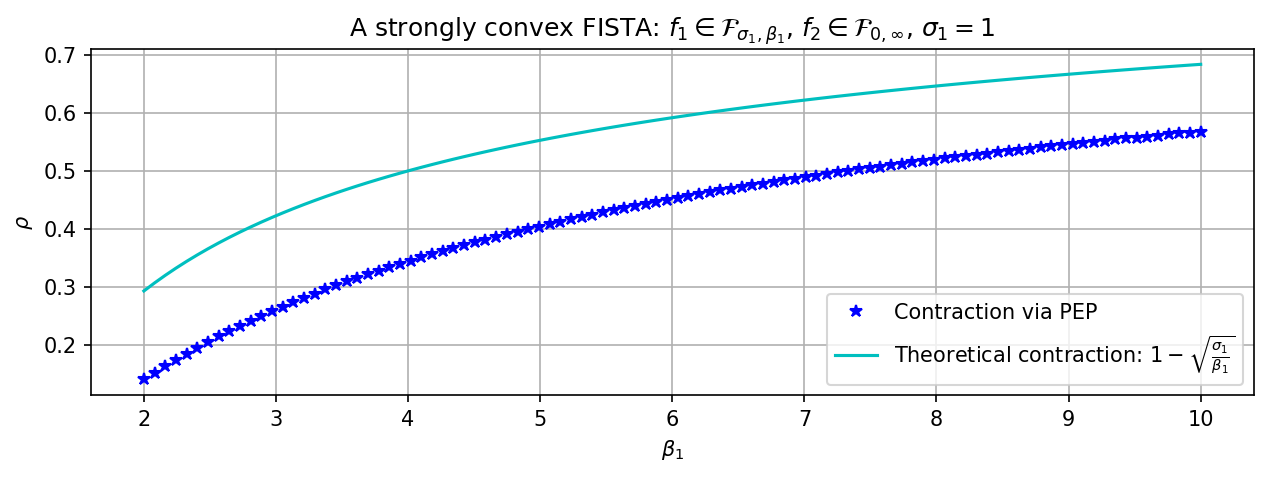

In [ ]:
# A strongly convex FISTA
sigma = 1

betas = []
rhos = []
PEP_rhos = []
for beta in np.linspace(2,10,100):
        choice = ("strongly_convex_FISTA", sigma, beta)
        (A,B,C,D) = select_algorithm(choice)
        m = C.shape[0]
        n = C.shape[1]
        #P = np.zeros((n+2*m,n+2*m)); P[0,0] = 1
        temp = np.block([C,D,-D])
        mid = np.zeros((m,m)); mid[0,0] = 1;
        P = temp.T@mid@temp
        p = np.zeros((m,1))
        T = np.zeros((n+2*m,n+2*m))
        t = np.zeros((m,1))

        list_of_sigmas_and_betas = [(sigma, beta),(0, float('inf'))]
        L = get_product_interpolation(list_of_sigmas_and_betas)

        if not has_Slater(A,B,C,D,list_of_sigmas_and_betas):
            continue

        PEP_rho = bisection(A,B,C,D,L,P,p,T,t,tol=0.001)
        if PEP_rho == -1:
            continue

        PEP_rhos.append(PEP_rho)
        betas.append(beta)
        rhos.append(1-np.sqrt(sigma/beta))

fig, axes = plt.subplots(dpi = 150, figsize=(10, 3))
axes.plot(betas, PEP_rhos,'b*')
axes.plot(betas, rhos,'c')
axes.grid(True)
axes.legend([r'Contraction via PEP', r'Theoretical contraction: $1-\sqrt{\frac{\sigma_1}{\beta_1}}$'])
axes.set_xlabel(r'$\beta_1$')
axes.set_ylabel(r'$\rho$')
axes.set_title(r'A strongly convex FISTA: $f_1\in\mathcal{F}_{\sigma_1,\beta_1}$, $f_2\in\mathcal{F}_{0,\infty}$, $\sigma_1 = '+f'{sigma}'+r'$');

---
### Davis-Yin three-operator splitting method

Let $\gamma,\lambda \in \mathbb{R}_{++}$, $0 \leq \sigma_i < \beta_i \leq +\infty$ and $f_i\in\mathcal{F}_{\sigma_i,\beta_i}$ for each $i=1,2,3$, and $\beta_{2}<\infty$. The three-operator splitting method by Davis and Yin is given by

\begin{align*}
    x_k &= \text{prox}_{\gamma f_1}(z_k), \\
    z_{k+\frac{1}{2}} &= 2x_k - z_k - \gamma \nabla f_2(x_k), \\
    z_{k+1} &= z_k + \lambda \left(\text{prox}_{\gamma f_3}\left(z_{k+\frac{1}{2}}\right) - x_k\right).
\end{align*}

By letting $\mathbf{x}_{k} = z_k$, $\mathbf{y}_{k}=(x_k,x_k,x_k+\lambda^{-1}(z_{k+1}-z_k))$ and $\mathbf{u}_{k}= (\gamma^{-1}(z_k-x_k),\gamma^{-1}(2x_k - z_k - z_{k + \frac{1}{2}}),\gamma^{-1}(z_{k+\frac{1}{2}}-x_k-\lambda^{-1}(z_{k+1}-z_{k})))$, we get

\begin{equation*}
    \begin{aligned}
        \mathbf{x}_{k+1}   &= \mathbf{x}_{k} +
        \left(\begin{bmatrix}
            -\gamma\lambda & -\gamma\lambda & -\gamma\lambda
        \end{bmatrix}\otimes\text{Id}\right)\mathbf{u}_{k}, \\
        \mathbf{y}_{k} &=    
        \left(\begin{bmatrix}
            1 \\
            1 \\
            1
        \end{bmatrix}\otimes \text{Id}\right)\mathbf{x}_{k} +
        \left(\begin{bmatrix}
            -\gamma & 0 & 0 \\
            -\gamma & 0 & 0 \\
            -2\gamma & -\gamma & -\gamma
        \end{bmatrix}\otimes\text{Id}\right)\mathbf{u}_{k}, \\
        \mathbf{u}_{k}&\in\boldsymbol{\partial}\mathbf{f}(\mathbf{y}_{k}),
    \end{aligned}
\end{equation*}

where $\boldsymbol{\partial}\mathbf{f}(\mathbf{y})=\partial f_1(y^{(1)})\times\{\nabla f_{2}(y^{(2)})\}\times\partial f_3(y^{(3)})$ for each $\mathbf{y}=(y^{(1)},y^{(2)},y^{(3)})\in\mathcal{H}^3$. We identify

\begin{align*}
    A &=1,&
    B &=\begin{bmatrix}
            -\gamma\lambda & -\gamma\lambda & -\gamma\lambda     
        \end{bmatrix},&
    C &=\begin{bmatrix}
            1 \\
            1 \\
            1
        \end{bmatrix},&
    D &=\begin{bmatrix}
            -\gamma & 0 & 0 \\
            -\gamma & 0 & 0 \\
            -2\gamma & -\gamma & -\gamma
        \end{bmatrix}.
\end{align*}

We pick

\begin{align*}
    (P,p,T,t) = \left(e_1e_1^\top,0,0,0\right)
\end{align*}

where $e_1$ is the first standard basis vector of $\mathbb{R}^{n+2m}$ ($n=1$ and $m=3$), and bisect to find the smallest $\rho$ for which a $(P,p,T,t,\rho)$-quadratic Lyapunov inequality exists. Note that

\begin{align*}
    \mathcal{Q}\left(P,\left(\mathbf{x}_k-\mathbf{x}_{\star},\mathbf{u}_{k},\mathbf{u}_{\star}\right)\right) + p^{\top}(\mathbf{F}_{k}-\mathbf{F}_{\star}) = \lVert{z_{k} - z_{\star}\rVert}^{2}.
\end{align*}

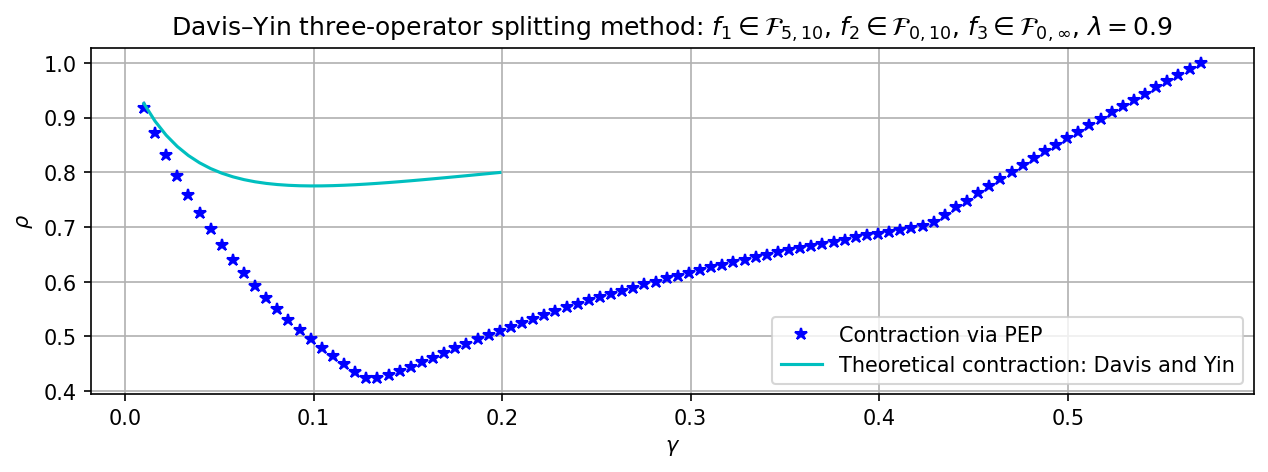

In [ ]:
# Davis-Yin three-operator splitting method
# Translation (our) f_1, f_2, f_3 => (Davis-Yin) f_2, f_3, f_1 or f_B, f_C, f_A
# See https://arxiv.org/pdf/1504.01032.pdf Theorem D.6 for rates in different cases.
# Minimizes f_1 + f_2 + f_3 all ccp and f_2 is beta_2 < +\infty smooth

def rate_1(lambd, gamma, sigma_1, beta_1):

    # See case 1 in Theorem D.6 | I think there is a typo in the rate they give
    #return 1 - (2*beta_1*gamma*lambd)/((1+gamma*beta_1)**2) # as written in the paper
    return 1 - (2*sigma_1*gamma*lambd)/((1+gamma*beta_1)**2) #

# Function data
sigma_1 = 5
beta_1 = 10
sigma_2 = 0
beta_2 = 10
sigma_3 = 0
beta_3 = float('inf')
list_of_sigmas_and_betas = [(sigma_1, beta_1),(sigma_2, beta_2),(sigma_3, beta_3)]
L = get_product_interpolation(list_of_sigmas_and_betas)

# DY data
lambd = 0.9

DY_gammas = []
DY_rhos = []
PEP_gammas = []
PEP_rhos = []
for gamma in np.linspace(0.01,0.6,100,endpoint=False):

    if gamma < 2/beta_2:
        DY_gammas.append(gamma)
        DY_rhos.append(rate_1(lambd, gamma, sigma_1, beta_1))

    choice = ("Davis–Yin_splitting", gamma, lambd)
    (A,B,C,D) = select_algorithm(choice)
    m = C.shape[0]
    n = C.shape[1]
    P = np.zeros((n+2*m,n+2*m)); P[0,0] = 1;
    p = np.zeros((m,1))
    T = np.zeros((n+2*m,n+2*m))
    t = np.zeros((m,1))

    if not has_Slater(A,B,C,D,list_of_sigmas_and_betas):
            continue

    PEP_rho = bisection(A,B,C,D,L,P,p,T,t,tol=0.001)
    if PEP_rho == -1:
        continue

    PEP_rhos.append(PEP_rho)
    PEP_gammas.append(gamma)

fig, axes = plt.subplots(dpi = 150, figsize=(10, 3))
axes.plot(PEP_gammas, PEP_rhos,'b*')
axes.plot(DY_gammas, DY_rhos,'c')
axes.grid(True)
axes.legend([r'Contraction via PEP', r'Theoretical contraction: Davis and Yin'])
axes.set_xlabel(r'$\gamma$')
axes.set_ylabel(r'$\rho$')
axes.set_title(r'Davis–Yin three-operator splitting method: $f_1\in\mathcal{F}_{5,10}$, $f_2\in\mathcal{F}_{0,10}$, $f_3\in\mathcal{F}_{0,\infty}$, $\lambda = 0.9$');

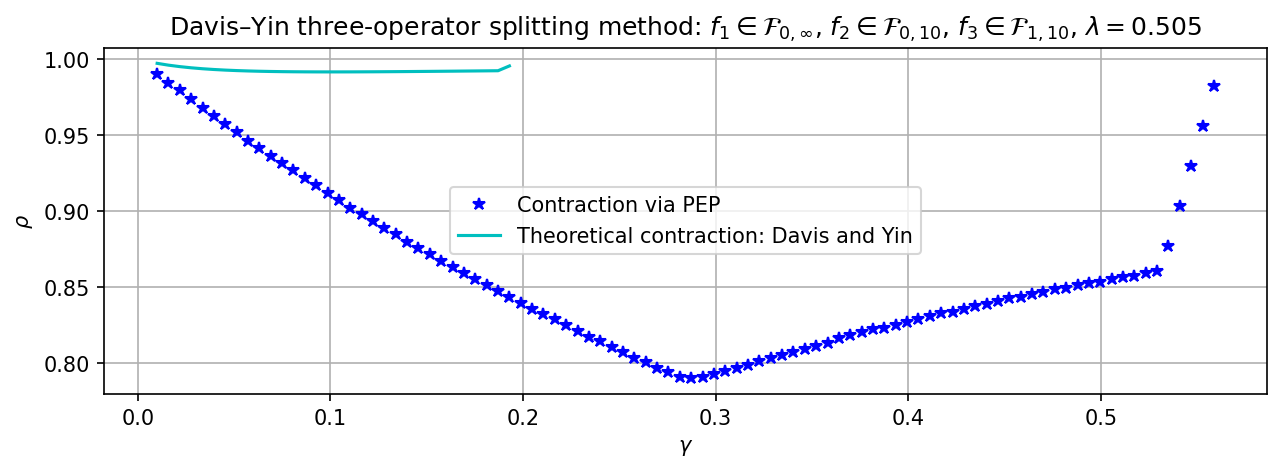

In [ ]:
# Davis-Yin three-operator splitting method
# Translation (our) f_1, f_2, f_3 => (Davis-Yin) f_2, f_3, f_1 or f_B, f_C, f_A
# See https://arxiv.org/pdf/1504.01032.pdf Theorem D.6 for rates in different cases.
# Minimizes f_1 + f_2 + f_3 all ccp and f_2 is beta_2 < +\infty smooth

def rate_2(lambd, gamma, sigma_3, beta_3, beta_2, alpha, eps):
    # See case 2 in Theorem D.6
    C_lambda = (lambd/3)*min((2*sigma_3*gamma)/((1+gamma*beta_3)**2),(lambd/4)*(1/(alpha*lambd)-1),(2/beta_2-gamma/eps)/gamma)
    return 1 - C_lambda

# Function data
sigma_1 = 0
beta_1 = float('inf')
sigma_2 = 0
beta_2 = 10
sigma_3 = 1
beta_3 = 10
list_of_sigmas_and_betas = [(sigma_1, beta_1),(sigma_2, beta_2),(sigma_3, beta_3)]
L = get_product_interpolation(list_of_sigmas_and_betas)

# DY data
eps = 0.99
alpha = 1/(2-eps)
lambd = 1/(2*alpha)

DY_gammas = []
DY_rhos = []
PEP_gammas = []
PEP_rhos = []
for gamma in np.linspace(0.01,0.6,100,endpoint=False):

    if gamma < eps*2/beta_2:
        DY_gammas.append(gamma)
        DY_rhos.append(rate_2(lambd, gamma, sigma_3, beta_3, beta_2, alpha, eps))

    choice = ("Davis–Yin_splitting", gamma, lambd)
    (A,B,C,D) = select_algorithm(choice)
    m = C.shape[0]
    n = C.shape[1]
    P = np.zeros((n+2*m,n+2*m)); P[0,0] = 1;
    p = np.zeros((m,1))
    T = np.zeros((n+2*m,n+2*m))
    t = np.zeros((m,1))

    if not has_Slater(A,B,C,D,list_of_sigmas_and_betas):
            continue

    PEP_rho = bisection(A,B,C,D,L,P,p,T,t,tol=0.001)
    if PEP_rho == -1:
        continue

    PEP_rhos.append(PEP_rho)
    PEP_gammas.append(gamma)

fig, axes = plt.subplots(dpi = 150, figsize=(10, 3))
axes.plot(PEP_gammas, PEP_rhos,'b*')
axes.plot(DY_gammas, DY_rhos,'c')
axes.grid(True)
axes.legend([r'Contraction via PEP', r'Theoretical contraction: Davis and Yin'])
axes.set_xlabel(r'$\gamma$')
axes.set_ylabel(r'$\rho$')
axes.set_title(r'Davis–Yin three-operator splitting method: $f_1\in\mathcal{F}_{0,\infty}$, $f_2\in\mathcal{F}_{0,10}$, $f_3\in\mathcal{F}_{1,10}$, $\lambda = 0.505$');

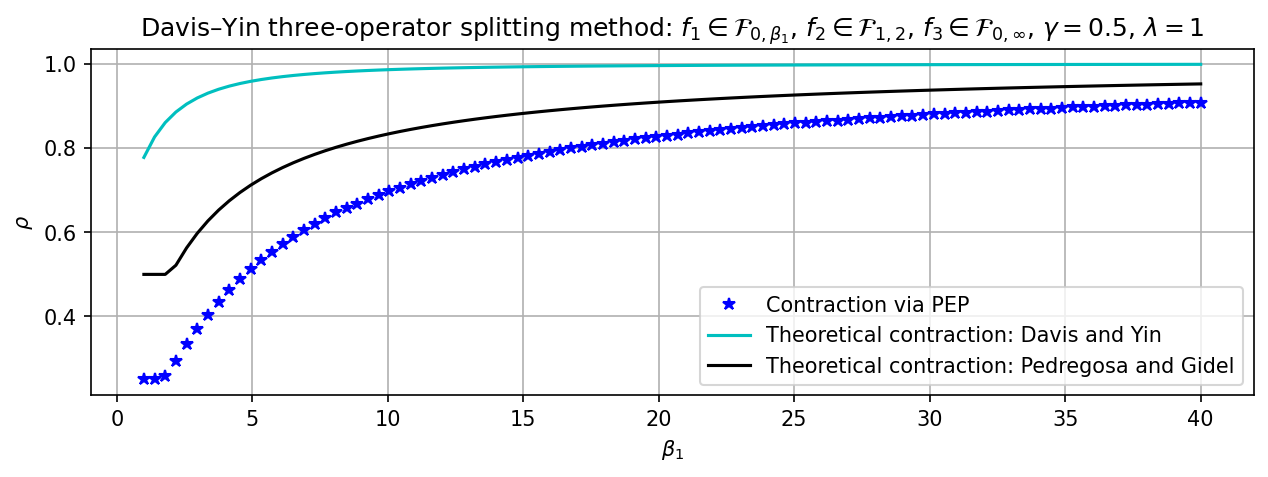

In [ ]:
# Davis-Yin three-operator splitting method
# Translation (our) f_1, f_2, f_3 => (Davis-Yin) f_2, f_3, f_1 or f_B, f_C, f_A
# See https://arxiv.org/pdf/1504.01032.pdf Theorem D.6 for rates in different cases.
# Minimizes f_1 + f_2 + f_3 all ccp and f_2 is beta_2 < +\infty smooth

def rate_6(beta_1, sigma_2, beta_2):
    # See case 6 in Theorem D.6 with lambd = 1. Take the limit eps -> 1 and eta -> 1/2.
    return  1 - sigma_2 / (beta_2*(1+beta_1/beta_2)**2)

def rate_PG(beta_1, sigma_2, beta_2):
    # The linear rate as given in Pedregosa and Gidel: http://proceedings.mlr.press/v80/pedregosa18a/pedregosa18a.pdf
    return 1 - min(sigma_2/beta_2,1/(1+beta_1/beta_2))

# Function data
sigma_1 = 0
#beta_1 = 10
sigma_2 = 1
beta_2 = 2
sigma_3 = 0
beta_3 = float('inf')

# DY data
gamma = 1/beta_2
lambd = 1
choice = ("Davis–Yin_splitting", gamma, lambd)
(A,B,C,D) = select_algorithm(choice)
m = C.shape[0]
n = C.shape[1]
P = np.zeros((n+2*m,n+2*m)); P[0,0] = 1;
p = np.zeros((m,1))
T = np.zeros((n+2*m,n+2*m))
t = np.zeros((m,1))

beta_1s = []
DY_rhos = []
PG_rhos = []
PEP_rhos = []
for beta_1 in np.linspace(1,40,100):

    list_of_sigmas_and_betas = [(sigma_1, beta_1),(sigma_2, beta_2),(sigma_3, beta_3)]
    L = get_product_interpolation(list_of_sigmas_and_betas)

    if not has_Slater(A,B,C,D,list_of_sigmas_and_betas):
            continue

    PEP_rho = bisection(A,B,C,D,L,P,p,T,t,tol=0.001)
    if PEP_rho == -1:
        continue

    PEP_rhos.append(PEP_rho)
    beta_1s.append(beta_1)
    DY_rhos.append(rate_6(beta_1, sigma_2, beta_2))
    PG_rhos.append(rate_PG(beta_1, sigma_2, beta_2))

fig, axes = plt.subplots(dpi = 150, figsize=(10, 3))
axes.plot(beta_1s, PEP_rhos,'b*')
axes.plot(beta_1s, DY_rhos,'c')
axes.plot(beta_1s, PG_rhos,'k')
axes.grid(True)
axes.legend([r'Contraction via PEP', r'Theoretical contraction: Davis and Yin', r'Theoretical contraction: Pedregosa and Gidel'])
axes.set_xlabel(r'$\beta_1$')
axes.set_ylabel(r'$\rho$')
axes.set_title(r'Davis–Yin three-operator splitting method: $f_1\in\mathcal{F}_{0,\beta_1}$, $f_2\in\mathcal{F}_{'+f'{sigma_2}'+r','+f'{beta_2}'+r'}$, $f_3\in\mathcal{F}_{0,\infty}$, $\gamma='+f'{gamma}'+r'$, $\lambda = 1$');

In [ ]:
#np.savetxt('DY_linear_rate6.csv', np.array([beta_1s,PEP_rhos,DY_rhos,PG_rhos]).T, delimiter=',',newline='\n',header='x-axis,a,b,c',comments='',fmt='%1.6f')

## Numerical examples - sublinear convergence

---
### Gradient method with heavy-ball momentum
Let $\gamma \in \mathbb{R}_{++}$, $\delta\in\mathbb{R}$, $0 < \beta_1 < +\infty$ and $f_{1}\in\mathcal{F}_{0,\beta_1}$. The gradient method with heavy-ball momentum is given by

\begin{align*}
    x_{k+1} = x_k-\gamma\nabla f_1(x_k)+\delta(x_k-x_{k-1}).
\end{align*}

By letting $\mathbf{x}_{k}=(x_{k},x_{k-1})$, $\mathbf{y}_k=x_{k}$, and $\mathbf{u}_k=\nabla f_1(x_k)$, we get

\begin{equation*}
    \begin{aligned}
        \mathbf{x}_{k+1}&=\left(\begin{bmatrix}1+\delta&-\delta\\1&0\end{bmatrix}\otimes \text{Id}\right)\mathbf{x}_{k}+\left(\begin{bmatrix}-\gamma\\0 \end{bmatrix}\otimes\text{Id}\right)\mathbf{u}_k,\\
        \mathbf{y}_k&=\left(\begin{bmatrix}1&0\end{bmatrix}\otimes \text{Id}\right)\mathbf{x}_{k}, \\
        \mathbf{u}_{k} &\in \boldsymbol{\partial}\mathbf{f}(\mathbf{y}_{k}),
    \end{aligned}
\end{equation*}

where $\boldsymbol{\partial}\mathbf{f}(y)=\{\nabla f_1(y)\}$ for each $y\in\mathcal{H}$. We identify

\begin{align*}
    A &=\begin{bmatrix}1+\delta&-\delta\\1&0\end{bmatrix},&
    B &=\begin{bmatrix}-\gamma\\0 \end{bmatrix},&
    C &=\begin{bmatrix}1&0\end{bmatrix},&
    D &=0.
\end{align*}

We pick
\begin{align*}
    (P,p,T,t,\rho) = (0,0,0,1,1)
\end{align*}
for ergodic $\mathcal{O}(1/k)$ function value suboptimality convergence.

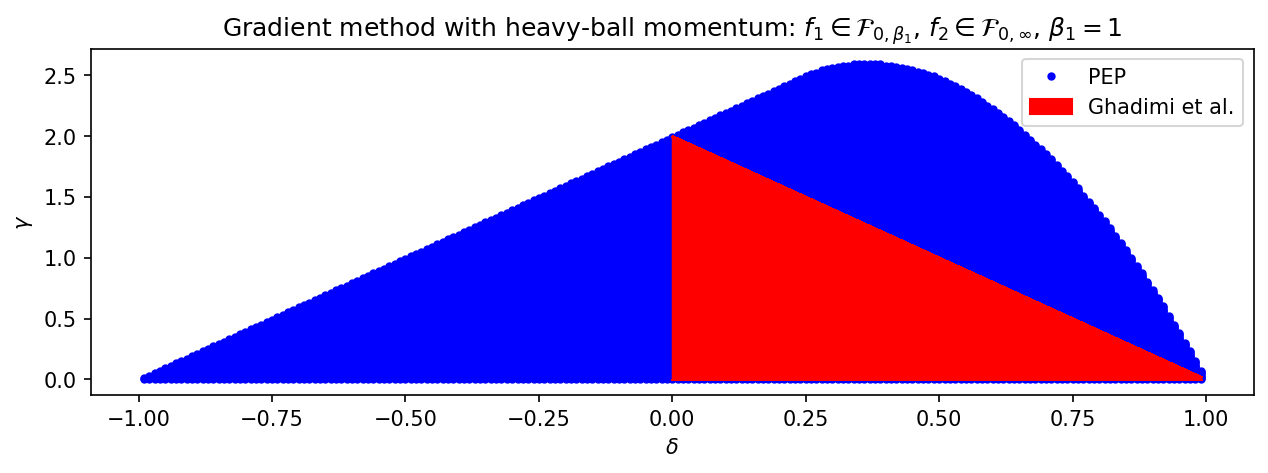

In [ ]:
# Gradient method with heavy-ball momentum

# We compare to:
# Ghadimi, Feyzmahdavian, Johansson - Global convergence of the Heavy-ball method for convex optimization
# https://arxiv.org/abs/1412.7457

sigma = 0
beta = 1
list_of_sigmas_and_betas = [(sigma, beta)]
L = get_product_interpolation(list_of_sigmas_and_betas)

PEP_gammas = []
PEP_deltas = []
Ghadimi_gammas = []
Ghadimi_deltas = []
for gamma in np.arange(0.001,3,0.01):
    for delta in np.arange(-1.1,1.1,0.01):
        choice = ("gradient_heavy-ball", gamma, delta)
        (A,B,C,D) = select_algorithm(choice)
        m = C.shape[0]
        n = C.shape[1]
        P = np.zeros((n+2*m,n+2*m))
        p = np.zeros((m,1))
        T = np.zeros((n+2*m,n+2*m))
        t = np.ones((m,1))
        rho = 1

        try:
            if find_quadratic_Lyapunov_function(A,B,C,D,L,P,p,T,t,rho):
                PEP_deltas.append(delta)
                PEP_gammas.append(gamma)
        except cp.error.SolverError:
            pass

        if (0 <= delta < 1):
            Ghadimi_deltas.append(delta)
            Ghadimi_gammas.append(2*(1-delta)/beta)

fig, axes = plt.subplots(dpi = 150, figsize=(10, 3))
axes.plot(PEP_deltas, PEP_gammas,'b.',zorder=0)
axes.fill_between(Ghadimi_deltas,Ghadimi_gammas,0,color='r')
axes.legend([r'PEP',r'Ghadimi et al.'])
axes.set_xlabel(r'$\delta$')
axes.set_ylabel(r'$\gamma$')
axes.set_title(r'Gradient method with heavy-ball momentum: $f_1\in\mathcal{F}_{0,\beta_1}$, $f_2\in\mathcal{F}_{0,\infty}$, $\beta_1='+f'{beta}'+r'$');

---
### Proximal gradient method with heavy-ball momentum terms
Let $\gamma \in \mathbb{R}_{++}$, $\delta_1,\delta_2\in\mathbb{R}$, $0 \leq \sigma_1 < \beta_1 < +\infty$, $f_{1}\in\mathcal{F}_{\sigma_1,\beta_1}$ and $f_{2}\in\mathcal{F}_{0,\infty}$. A proximal gradient method with heavy-ball momentum terms is given by

\begin{align*}
    x_{k+1} = \text{prox}_{\gamma f_2}(x_k-\gamma\nabla f_1(x_k)+\delta_1(x_k-x_{k-1}))+\delta_2(x_k-x_{k-1}).
\end{align*}

By letting  $\mathbf{x}_{k}=(x_{k},x_{k-1})$, $\mathbf{y}_{k}=(x_k,x_{k+1}-\delta_2(x_k-x_{k-1}))$, $\mathbf{u}_{k}=(\nabla f_1(x_k),\gamma^{-1}(x_k-\gamma \nabla f_1(x_k)+(\delta_1+\delta_2)(x_k-x_{k-1})-x_{k+1}))$, we get

\begin{equation*}
    \begin{aligned}
        \mathbf{x}_{k+1}   &=  
        \left(\begin{bmatrix}1+\delta_1+\delta_2&-\delta_1-\delta_2\\1&0\end{bmatrix}\otimes \text{Id}\right)\mathbf{x}_{k} +
        \left(\begin{bmatrix}-\gamma&-\gamma\\0&0 \end{bmatrix}\otimes\text{Id}\right)\mathbf{u}_{k} \\
        \mathbf{y}_{k} &=    
        \left(\begin{bmatrix}1&0\\1+\delta_1&-\delta_1\end{bmatrix}\otimes \text{Id}\right)\mathbf{x}_{k} +
        \left(\begin{bmatrix}0&0\\-\gamma&-\gamma \end{bmatrix}\otimes\text{Id}\right)\mathbf{u}_{k}, \\
        \mathbf{u}_{k}&\in\boldsymbol{\partial}\mathbf{f}(\mathbf{y}_{k}),
    \end{aligned}
\end{equation*}

where $\boldsymbol{\partial}\mathbf{f}(\mathbf{y})=\{\nabla f_{1}(y^{(1)})\}\times\partial f_2(y^{(2)})$ for each $\mathbf{y}=(y^{(1)},y^{(2)})\in\mathcal{H}^2$. We identify

\begin{align*}
    A &=\begin{bmatrix}1+\delta_1+\delta_2&-\delta_1-\delta_2\\1&0\end{bmatrix},&
    B &=\begin{bmatrix}-\gamma&-\gamma\\0&0 \end{bmatrix},&
    C &=\begin{bmatrix}1&0\\1+\delta_1&-\delta_1\end{bmatrix},&
    D &=\begin{bmatrix}0&0\\-\gamma&-\gamma \end{bmatrix}.
\end{align*}


We pick
\begin{align*}
    (P,p,T,t,\rho) = \left(0,0,
    \begin{bmatrix}
        C & D & -D\\
        0 & 0 & I
    \end{bmatrix}^{\top}
    \begin{bmatrix}
        0 & -\tfrac{1}{2}I\\
        -\tfrac{1}{2}I & 0
    \end{bmatrix}
    \begin{bmatrix}
        C & D & -D\\
        0 & 0 & I
    \end{bmatrix}
    ,\mathbf{1},1\right)
\end{align*}
for ergodic $\mathcal{O}(1/k)$ convergence of the duality gap.

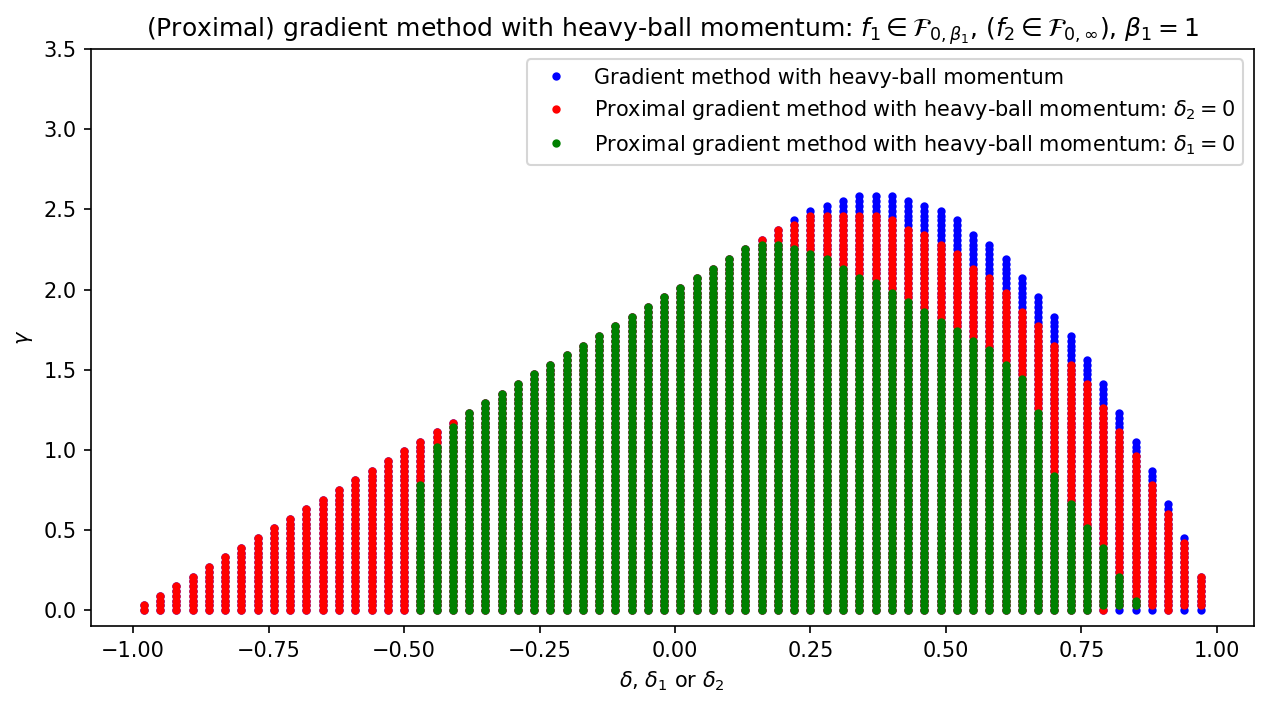

In [ ]:
# Proximal gradient method with heavy-ball momentum

sigma_1 = 0
beta_1 = 1
sigma_2 = 0
beta_2 = float('inf')
list_of_sigmas_and_betas_no_prox = [(sigma_1, beta_1)]
list_of_sigmas_and_betas = [(sigma_1, beta_1),(sigma_2, beta_2)]
L_no_prox = get_product_interpolation(list_of_sigmas_and_betas_no_prox)
L = get_product_interpolation(list_of_sigmas_and_betas)

no_prox_gammas = []
no_prox_deltas = []
inner_gammas = []
inner_deltas = []
outer_gammas = []
outer_deltas = []
for gamma in np.arange(0.001,3,0.03):
    for delta in np.arange(-1.1,1.1,0.03):
        choice = ("gradient_heavy-ball", gamma, delta)
        (A,B,C,D) = select_algorithm(choice)
        m = C.shape[0]
        n = C.shape[1]
        P = np.zeros((n+2*m,n+2*m))
        p = np.zeros((m,1))
        T = np.zeros((n+2*m,n+2*m))
        t = np.ones((m,1))
        rho = 1

        try:
            if find_quadratic_Lyapunov_function(A,B,C,D,L_no_prox,P,p,T,t,rho):
                no_prox_deltas.append(delta)
                no_prox_gammas.append(gamma)
        except cp.error.SolverError:
            pass

        choice = ("proximal_gradient_heavy-ball_terms", gamma, delta, 0)
        (A,B,C,D) = select_algorithm(choice)
        m = C.shape[0]
        n = C.shape[1]
        P = np.zeros((n+2*m,n+2*m))
        p = np.zeros((m,1))
        temp = np.block([[C,D,-D],[np.zeros((m,n)),np.zeros((m,m)),np.eye(m)]])
        mid = np.block([[np.zeros((m,m)),-0.5*np.eye(m)],[-0.5*np.eye(m),np.zeros((m,m))]])
        T = temp.T@mid@temp
        t = np.ones((m,1))
        rho = 1

        try:
            if find_quadratic_Lyapunov_function(A,B,C,D,L,P,p,T,t,rho):
                inner_deltas.append(delta)
                inner_gammas.append(gamma)
        except cp.error.SolverError:
            pass

        choice = ("proximal_gradient_heavy-ball_terms", gamma, 0, delta)
        (A,B,C,D) = select_algorithm(choice)
        m = C.shape[0]
        n = C.shape[1]
        P = np.zeros((n+2*m,n+2*m))
        p = np.zeros((m,1))
        temp = np.block([[C,D,-D],[np.zeros((m,n)),np.zeros((m,m)),np.eye(m)]])
        mid = np.block([[np.zeros((m,m)),-0.5*np.eye(m)],[-0.5*np.eye(m),np.zeros((m,m))]])
        T = temp.T@mid@temp
        t = np.ones((m,1))
        rho = 1

        try:
            if find_quadratic_Lyapunov_function(A,B,C,D,L,P,p,T,t,rho):
                outer_deltas.append(delta)
                outer_gammas.append(gamma)
        except cp.error.SolverError:
            pass

fig, axes = plt.subplots(dpi = 150, figsize=(10, 5))
axes.plot(no_prox_deltas, no_prox_gammas,'b.',zorder=0)
axes.plot(inner_deltas, inner_gammas,'r.',zorder=5)
axes.plot(outer_deltas, outer_gammas,'g.',zorder=10)
axes.legend([r'Gradient method with heavy-ball momentum',r'Proximal gradient method with heavy-ball momentum: $\delta_2 = 0$',r'Proximal gradient method with heavy-ball momentum: $\delta_1 = 0$'])
axes.set_xlabel(r'$\delta$, $\delta_1$ or $\delta_2$')
axes.set_ylabel(r'$\gamma$')
axes.set_ylim(-0.1,3.5)
axes.set_title(r'(Proximal) gradient method with heavy-ball momentum: $f_1\in\mathcal{F}_{0,\beta_1}$, $(f_2\in\mathcal{F}_{0,\infty})$, $\beta_1='+f'{beta_1}'+r'$');

---
### Chambolle-Pock method


We pick
\begin{align*}
    (P,p,T,t,\rho) = \left(0,0,
    \begin{bmatrix}
        C & D & -D\\
        0 & 0 & I
    \end{bmatrix}^{\top}
    \begin{bmatrix}
        0 & -\tfrac{1}{2}I\\
        -\tfrac{1}{2}I & 0
    \end{bmatrix}
    \begin{bmatrix}
        C & D & -D\\
        0 & 0 & I
    \end{bmatrix}
    ,\mathbf{1},1\right)
\end{align*}
for ergodic $\mathcal{O}(1/k)$ convergence of the duality gap.

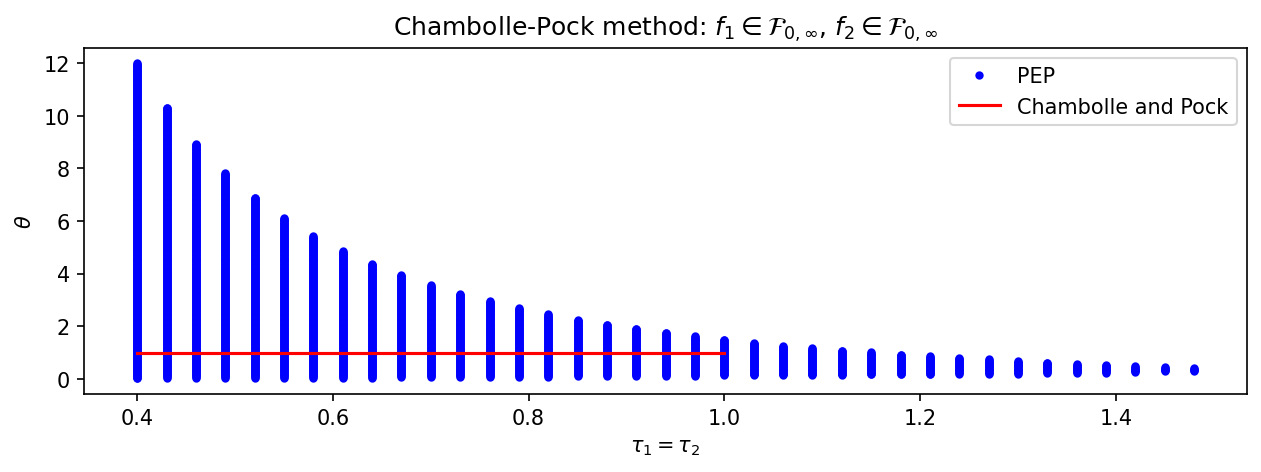

In [ ]:
# Chambolle-Pock method

# We compare to:
# Chambolle, Pock - A First-Order Primal-Dual Algorithm for Convex Problems with Applications to Imaging
# https://link.springer.com/article/10.1007/s10851-010-0251-1

# Function data
sigma_1 = 0
beta_1 = float('inf')
sigma_2 = 0
beta_2 = float('inf')
list_of_sigmas_and_betas = [(sigma_1, beta_1),(sigma_2, beta_2)]
L = get_product_interpolation(list_of_sigmas_and_betas)

PEP_taus = []
PEP_thetas = []
for tau in np.arange(0.4,1.5,0.03):
    for theta in np.arange(-1,13,0.03):
            choice = ("Chambolle-Pock", tau, tau, theta)
            (A,B,C,D) = select_algorithm(choice)
            m = C.shape[0]
            n = C.shape[1]
            P = np.zeros((n+2*m,n+2*m))
            p = np.zeros((m,1))
            temp = np.block([[C,D,-D],[np.zeros((m,n)),np.zeros((m,m)),np.eye(m)]])
            mid = np.block([[np.zeros((m,m)),-0.5*np.eye(m)],[-0.5*np.eye(m),np.zeros((m,m))]])
            T = temp.T@mid@temp
            t = np.ones((m,1))
            rho = 1

            try:
                if find_quadratic_Lyapunov_function(A,B,C,D,L,P,p,T,t,rho):
                    PEP_taus.append(tau)
                    PEP_thetas.append(theta)
            except cp.error.SolverError:
                pass

fig, axes = plt.subplots(dpi = 150, figsize=(10, 3))
axes.plot(PEP_taus, PEP_thetas,'b.',zorder=0)
axes.plot([0.4,1], [1,1],'r',zorder=10)
axes.legend([r'PEP',r'Chambolle and Pock'])
axes.set_xlabel(r'$\tau_1 = \tau_2$')
axes.set_ylabel(r'$\theta$')
axes.set_title(r'Chambolle-Pock method: $f_1\in\mathcal{F}_{0,\infty}$, $f_2\in\mathcal{F}_{0,\infty}$');